# Setup

In [2]:
# Import packages
import sys
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import copy
import collections
import theano
import theano.tensor as tt
from sklearn.svm import LinearSVC
from sklearn.model_selection import PredefinedSplit, KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
warnings.filterwarnings('ignore')

import pickle
def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)
    
# change default plotting
plt.rcParams.update({'font.size': 22, 'figure.figsize': (12,3)})

demo of make_vonmises function:


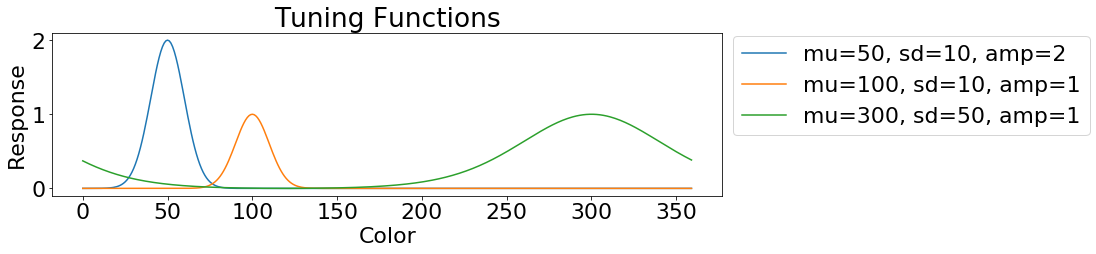

In [205]:
# Convenience functions
k2sd = lambda k : np.sqrt( -2 * np.log( sp.special.iv(1,k) / sp.special.iv(0,k) ) )

def sd2k(S):
    try:
        len(S)
    except:
        S = np.array([S])
    R = np.exp(-S**2/2)
    K = 1/(R**3 - 4 * R**2 + 3 * R)
    if np.any(R < 0.85):
        K[R < 0.85] = -0.4 + 1.39 * R[R < 0.85] + 0.43/(1 - R[R < 0.85])
    if np.any(R < 0.53):
        K[R < 0.53] = 2 * R[R < 0.53] + R[R < 0.53]**3 + (5 * R[R < 0.53]**5)/6
    if len(S) == 1:
        K = float(K)
    return K

def dim_reduce(x):
    if len(x)==0:
        return x
    else:
        least_freq_feature = collections.Counter(x).most_common()[-1][0]
        least_freq_feature_cnt = len(x[x==least_freq_feature])
        y = [];
        for f in np.unique(x):
            y = np.concatenate((y,np.repeat(f,len(x[x==f])-least_freq_feature_cnt)))
        return y

def half_dim_reduce(x):
    least_freq_feature = collections.Counter(x).most_common()[-1][0]
    least_freq_feature_cnt = len(x[x==least_freq_feature])/2
    y = [];
    for f in np.unique(x):
        y = np.concatenate((y,np.repeat(f,len(x[x==f])-least_freq_feature_cnt)))
    return y

def third_dim_reduce(x):
    least_freq_feature = collections.Counter(x).most_common()[-1][0]
    least_freq_feature_cnt = 2/3 * len(x[x==least_freq_feature])
    y = [];
    for f in np.unique(x):
        y = np.concatenate((y,np.repeat(f,len(x[x==f])-least_freq_feature_cnt)))
    return y

def wrap360(a,b):
    try:
        len(a)
    except:
        a = np.array([a]); b= np.array([b])
    diff = np.full(len(a),np.nan)
    for k in np.arange(len(a)):
        diff[k] = b[k] - a[k]
        if diff[k] < -180:
            diff[k] = b[k] - a[k] + 360
        elif diff[k] > 180:
            diff[k] = b[k] - a[k] - 360
    return diff

def within360(y):
    x = copy.deepcopy(y)
    try:
        len(x)
    except:
        x = np.array([x])
    x[x>359] = x[x>359]-360
    x[x>359] = x[x>359]-360
    x[x<0] = x[x<0]+360
    return x

import numpy as np

def normalize(x):
    if np.any(np.isnan((x - np.min(x)) / (np.max(x) - np.min(x)))):
        return x
    else:
        return (x - np.min(x)) / (np.max(x) - np.min(x))
    
def norm0(x):
    return x / np.max(x)

def betw01(x):
    if (x>1):
        x=1
    elif (x<0):
        x=0
    return x

def sumfix(x):
    if (np.min(x)<0):
        x = x - np.min(x)
    return x / np.sum(x)

def within180(x):
    x[x<0] = x[x<0]+360
    x[x>180] = x[x>180]-360
    return np.abs(x)

def within_pi(k):
    while (np.any(k<np.pi) or np.any(k>np.pi)):
        k[k>np.pi] -= np.pi*2
        k[k<-np.pi] += np.pi*2
    return k

def in360_scalar(x):
    while x>359:
        x=x-360
    while x<0:
        x=x+360
    return x

def basis_features(basis_points,trial_features):
    b = np.argmin(np.abs(np.subtract.outer(np.concatenate([basis_points,[basis_points[0]+360]]), trial_features)),axis=0)
    b[b==np.max(b)]=0
    return b

nchannels=6
def make_vonmises(xx,mu,sd,amp=1):
    res = np.exp(sd2k(np.deg2rad(sd))*np.cos(np.deg2rad(xx-mu)))/(2*np.pi*sp.special.i0(sd2k(np.deg2rad(sd))))
    res[np.isnan(res)] = 0 # if requesting a stick function (very small sd), return a stick function
    if np.all(res==0):
        res[int(np.floor(mu))] = amp
    norm_res = (res - np.min(res)) / (np.max(res) - np.min(res)) 
    return norm_res * amp

def make_vonmises_iter(xx,mu,sd,amp=np.ones(nchannels)/nchannels):
    res1 = np.full( (360,len(mu)) , np.nan)
    for i in range(len(mu)):
        res = np.exp(sd2k(np.deg2rad(sd[i]))*np.cos(np.deg2rad(xx-mu[i])))/(2*np.pi*sp.special.i0(sd2k(np.deg2rad(sd[i]))))
        res[np.isnan(res)] = 0 
        if np.all(res==0):
            res[int(np.floor(mu[i]))] = amp[i]
        norm_res = (res - np.min(res)) / (np.max(res) - np.min(res)) 
        res1[:,i] = norm_res * amp[i]
    return res1
    
print('demo of make_vonmises function:')
plt.plot(make_vonmises(np.linspace(0,359,360),50,10,[2]),label="mu=50, sd=10, amp=2")
plt.plot(make_vonmises(np.linspace(0,359,360),100,10,[1]),label="mu=100, sd=10, amp=1")
plt.plot(make_vonmises(np.linspace(0,359,360),300,50,[1]),label="mu=300, sd=50, amp=1")
plt.xlabel('Color')
plt.ylabel('Response')
plt.legend(bbox_to_anchor=(1, 1.05))
plt.title("Tuning Functions")
plt.show()

In [222]:
### function to automate voxel simulation ###
def sim_vox(plotting=0):
    # Simulate voxels 
    trial_features = within360(np.random.permutation(np.arange(ntrials)))
#     for t in range(ntrials):
#         if trial_features[t] < 60:
#             trial_features[t] = np.random.randint(300)+60
#     trial_features = np.array([np.arange(360),np.arange(360)]).flatten()
    trial_conds = np.tile(np.array([0,1]),ntrials//2)
    trial_by_vox = np.full((ntrials,nvoxels),np.nan)
    for vox in np.arange(nvoxels):
        vox_tuning = make_vonmises( 
            np.linspace(0,359,360),
            vox_mu[vox],
            vox_sd[vox],
            vox_amp[vox])
        for trial in range(ntrials):
            vox_w_noise = vox_tuning[trial_features[trial]] + (np.random.rand()*vox_noise)
            vox_w_noise_and_gain = vox_w_noise * (trial_conds[trial]*vox_gain_diff + 1)
            trial_by_vox[trial,vox] = np.sum(vox_w_noise_and_gain)
    
    # use trial_by_vox and trial_features to obtain an "observed" distribution for later MCMC/VI
    # I think this is called inverse transform sampling?
    vox_betas = trial_by_vox.flatten()
    features = np.repeat(trial_features,nvoxels)
    vox_prob = [np.sum([vox_betas[j] for j in np.where(features==f)[0]]) / np.sum(vox_betas)
                for f in range(360)]
    vox_prob = vox_prob + (1-np.sum(vox_prob))/len(vox_prob) # ensure probabilites sum to 1
    vox_dist=[]
    num_t = 5000
    while len(dim_reduce(vox_dist)) <= 5000: # chopping off redundant uniform noise, then sampling more
        vox_dist=[];
        for f in range(360):
            vox_dist=np.concatenate((vox_dist,np.repeat(f,vox_prob[f]*num_t)))
        num_t = num_t + 1000;
        
    if plotting:
        with plt.rc_context(rc={'font.size': 14, 'figure.figsize': (12,1)}):
            plt.hist(vox_mu,bins=30)
            plt.ylabel('Count')
            plt.title("Each voxel's maximal color preference")
            plt.show()
            plt.hist(vox_amp,bins=30)
            plt.ylabel('Count')
            plt.title("Each voxels's amplitude if maximal stimulus")
            plt.show()
            plt.hist(vox_sd,bins=30)
            plt.ticklabel_format(useOffset=False)
            plt.ylabel('Count')
            plt.title("Each voxel's sd of tuning function")
            plt.show()
    return vox_dist, np.array(trial_features), trial_conds, vox_betas, features, trial_by_vox


# Simulate Data

running sim_vox


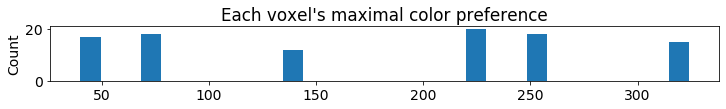

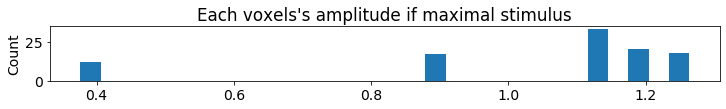

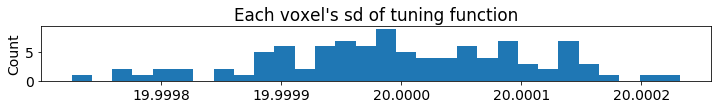

In [234]:
np.random.seed(1)

ntrials = 360*2
nvoxels = 100
vox_mu_sd = 0
vox_sd_mu = 20
vox_sd_sd = 0.0001
vox_gain_diff = 0 # difference in amplitude between trial conditions
vox_noise = 1 # introduce noise for every voxel
feature_space = np.linspace(0,359,360) # full range of our continuous feature (here 360 degrees in color wheel)

nchannels = 6
vox_nchannels = 6
vox_mu_basis = np.array([ 40.,  72., 142., 222., 257., 324.]) 
# vox_mu_basis = np.linspace(0,360-(360//vox_nchannels),vox_nchannels)+15 # ground truth voxel receptive fields
basis_points = vox_mu_basis
vox_amp_basis = np.ones(vox_nchannels) # amplitude for given features

# # randomize the amplitudes of the vox basis set
y_amp = pm.Dirichlet.dist(a=np.ones(nchannels)/nchannels)
vox_amp_basis = np.mean(y_amp.random(size=25),axis=0) * nchannels

y_mu = pm.NormalMixture.dist(w=np.ones(vox_nchannels)/vox_nchannels, 
                          mu=vox_mu_basis,
                          sigma=np.ones(vox_nchannels)*vox_mu_sd)
vox_mu = within360(y_mu.random(size=nvoxels))

vox_amp=np.full(nvoxels,np.nan)
for vox in np.arange(nvoxels):
    closest_basis = np.argmin( np.abs( wrap360(np.repeat(vox_mu[vox],len(vox_mu_basis)),vox_mu_basis) ) )
    vox_amp[vox] = vox_amp_basis[closest_basis]
    
y_sd = pm.TruncatedNormal.dist(mu=vox_sd_mu, sd=vox_sd_sd, lower=0)
vox_sd = y_sd.random(size=nvoxels)
channel_sd = np.ones(nchannels)*np.mean(vox_sd)
# vox_sd[(vox_mu<182) & (vox_mu>107)] = 40 #make the first channel wider than the rest
# channel_sd[1] = 40

print('running sim_vox')

vox_dist, trial_features, trial_conds, vox_betas, features, trial_by_vox = sim_vox(plotting=1)

basis_set = make_vonmises_iter(feature_space, basis_points, channel_sd) 
actual_weights = basis_set[trial_features,:]

# tst_mae, tst_overlap = auto_recon_plotting_old(basis_points,channel_sd,trial_features,trial_by_vox)


# Encoding Model

## Prep the model

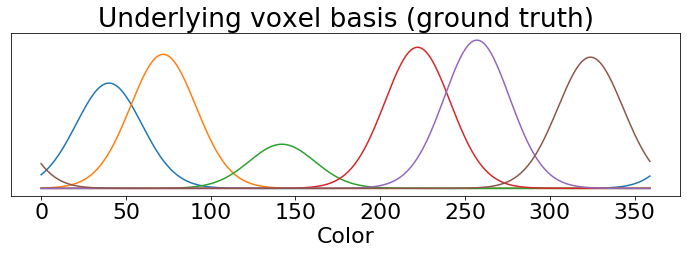

19818


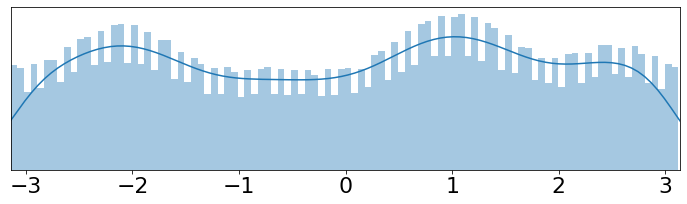

5058


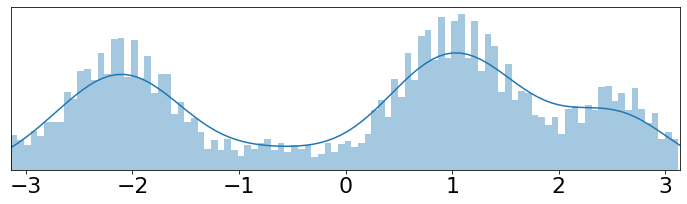

In [235]:
# Plot simulated voxel tunings (ground truth)               
plt.plot(make_vonmises_iter(np.linspace(0,359,360),vox_mu_basis,channel_sd,vox_amp_basis))
plt.title('Underlying voxel basis (ground truth)') 
# plt.ylabel('Response')
plt.xlabel('Color')
plt.yticks([])
plt.show()

# Plot input data before skimming (dim_reduce)
print(len(vox_dist))
sns.distplot(np.deg2rad(vox_dist)-np.pi,bins=100)
plt.xlim([-np.pi,np.pi])
plt.yticks([])
plt.show()

# Plot input data: obs is what gets fed into the model
print(len(dim_reduce(vox_dist)))
obs = np.deg2rad(dim_reduce(vox_dist))-np.pi
sns.distplot(obs,bins=100)
plt.xlim([-np.pi,np.pi])
plt.yticks([])
plt.show()

In [236]:
# allow pymc3 to use scipy's modified bessel function
from theano.compile.ops import as_op
@as_op(itypes=[tt.dscalar], otypes=[tt.dscalar])
def k2sd_to_deg_op(k):
    return np.rad2deg(np.sqrt( -2 * np.log( sp.special.iv(1,k) / sp.special.iv(0,k) ) ))

# see this thread's last post for what this code does: 
# https://discourse.pymc.io/t/how-does-pymc3-interpret-von-mises-boundaries/4453/7
from pymc3.distributions.distribution import (Continuous, draw_values, generate_samples)
from pymc3.distributions import transforms
from pymc3.theanof import floatX
from pymc3.distributions.special import log_i0
from pymc3.distributions.dist_math import (
    alltrue_elemwise, betaln, bound, gammaln, i0e, incomplete_beta, logpow,
    normal_lccdf, normal_lcdf, SplineWrapper, std_cdf, zvalue)

def assert_negative_support(var, label, distname, value=-1e-6):
    # Checks for evidence of positive support for a variable
    if var is None:
        return
    try:
        # Transformed distribution
        support = np.isfinite(var.transformed.distribution.dist
                              .logp(value).tag.test_value)
    except AttributeError:
        try:
            # Untransformed distribution
            support = np.isfinite(var.distribution.logp(value).tag.test_value)
        except AttributeError:
            # Otherwise no direct evidence of non-positive support
            support = False

    if np.any(support):
        msg = "The variable specified for {0} has negative support for {1}, ".format(
            label, distname)
        msg += "likely making it unsuitable for this parameter."
        warnings.warn(msg)

class VonMises(Continuous):
    R"""
    Univariate VonMises log-likelihood.

    The pdf of this distribution is

    .. math::

        f(x \mid \mu, \kappa) =
            \frac{e^{\kappa\cos(x-\mu)}}{2\pi I_0(\kappa)}

    where :math:`I_0` is the modified Bessel function of order 0.

    .. plot::

        import matplotlib.pyplot as plt
        import numpy as np
        import scipy.stats as st
        plt.style.use('seaborn-darkgrid')
        x = np.linspace(-np.pi, np.pi, 200)
        mus = [0., 0., 0.,  -2.5]
        kappas = [.01, 0.5,  4., 2.]
        for mu, kappa in zip(mus, kappas):
            pdf = st.vonmises.pdf(x, kappa, loc=mu)
            plt.plot(x, pdf, label=r'$\mu$ = {}, $\kappa$ = {}'.format(mu, kappa))
        plt.xlabel('x', fontsize=12)
        plt.ylabel('f(x)', fontsize=12)
        plt.legend(loc=1)
        plt.show()

    ========  ==========================================
    Support   :math:`x \in [-\pi, \pi]`
    Mean      :math:`\mu`
    Variance  :math:`1-\frac{I_1(\kappa)}{I_0(\kappa)}`
    ========  ==========================================

    Parameters
    ----------
    mu : float
        Mean.
    kappa : float
        Concentration (\frac{1}{kappa} is analogous to \sigma^2).
    """

    def __init__(self, mu=0.0, kappa=None, transform='circular',
                 *args, **kwargs):
        if transform == 'circular':
            transform = transforms.Circular()
        super().__init__(transform=transform, *args, **kwargs)
        self.mean = self.median = self.mode = self.mu = mu = tt.as_tensor_variable(floatX(mu))
        self.kappa = kappa = tt.as_tensor_variable(floatX(kappa))

        assert_negative_support(kappa, 'kappa', 'VonMises')

    def random(self, point=None, size=None):
        """
        Draw random values from VonMises distribution.

        Parameters
        ----------
        point : dict, optional
            Dict of variable values on which random values are to be
            conditioned (uses default point if not specified).
        size : int, optional
            Desired size of random sample (returns one sample if not
            specified).

        Returns
        -------
        array
        """
        mu, kappa = draw_values([self.mu, self.kappa],
                                point=point, size=size)
        return within_pi(generate_samples(sp.stats.vonmises.rvs, loc=mu, kappa=kappa,
                                dist_shape=self.shape,
                                size=size))

    def logp(self, value):
        """
        Calculate log-probability of VonMises distribution at specified value.

        Parameters
        ----------
        value : numeric
            Value(s) for which log-probability is calculated. If the log probabilities for multiple
            values are desired the values must be provided in a numpy array or theano tensor

        Returns
        -------
        TensorVariable
        """
        mu = self.mu
        kappa = self.kappa
        return bound(kappa * tt.cos(mu - value) - (tt.log(2 * np.pi) + log_i0(kappa)),
                     kappa > 0, value >= -np.pi, value <= np.pi)

pm.VonMises = VonMises

## Initialize the model

See list of models at bottom of document. Initialize the model(s) you want to run.

In [237]:
### X = pm.Minibatch(obs, batch_size=500) # VI ONLY: model runs faster if we fit smaller batches of data at a time
# del shared_k_2_channels
with pm.Model() as shared_k_6_channels:    
    
#     # separate precision parameters per channel
#     kappas = [pm.Bound(pm.Gamma,
#                    lower = .609, # 90 deg sd
#                    upper = 33.33) # 10 deg sd
#              ('kappa_%d' % i,2.,.01)
#              for i in range(nchannels)]
    
    # shared precision parameter per channel
    kappas = pm.Bound(pm.Gamma,lower = .609,upper = 33.33)('kappa',2.,.01)
    
    # bounded von mises distribution per channel
    mus = [pm.Uniform('mu_%d' % i, 
                   lower = (2*np.pi)/nchannels*i - np.pi,
                   upper = ((2*np.pi)/nchannels*i + (2*np.pi)/nchannels) - np.pi)
       for i in range(nchannels)]
    
    # weights of each mixture component
    p = pm.Dirichlet('p', a=np.array([1.]*(nchannels)))
    
    dists = [
        pm.VonMises.dist(mu=mus[0],kappa=kappas),
        pm.VonMises.dist(mu=mus[1],kappa=kappas),
        pm.VonMises.dist(mu=mus[2],kappa=kappas),
        pm.VonMises.dist(mu=mus[3],kappa=kappas),
        pm.VonMises.dist(mu=mus[4],kappa=kappas),
        pm.VonMises.dist(mu=mus[5],kappa=kappas),
    ]
    
    # Convenience transform: radians (-pi to pi) to degrees (0 to 359)
    mus_deg = [pm.Deterministic('mu_deg_%d' % i,
                              np.rad2deg(mus[i]+np.pi))
              for i in range(nchannels)]
    
#     # Convenience transform: kappa (in radians) to sd (in degrees)
#     sds = [pm.Deterministic('sd_deg_%d' % i,
#                 k2sd_to_deg_op(kappas[i]))
#           for i in range(nchannels)]
    
        # Convenience transform: kappa (in radians) to sd (in degrees)
    sds = pm.Deterministic('sd_deg', k2sd_to_deg_op(kappas))

    
#     # Specify the likelihood
    y = pm.Mixture('y', w=p, comp_dists=dists, observed=obs) #, total_size=obs.shape)


In [170]:
#example of one of the models
# X = pm.Minibatch(obs, batch_size=500) # VI ONLY: model runs faster if we fit smaller batches of data at a time
nchannels=6
with pm.Model() as indiv_k_6_channels:
    mus = [pm.Uniform('mu_%d' % i, 
                       lower = (2*np.pi)/nchannels*i - np.pi,
                       upper = ((2*np.pi)/nchannels*i + (2*np.pi)/nchannels) - np.pi) 
           for i in range(nchannels)] # 60 deg spaces

#     mus = [pm.Bound(pm.VonMises,
#                    lower = (2*np.pi)/nchannels*i - np.pi - (2*np.pi)/nchannels/2,
#                    upper = ((2*np.pi)/nchannels*i + (2*np.pi)/nchannels) - np.pi + (2*np.pi)/nchannels/2)
#                    ('mu_%d' % i,
#                    mu = (((2*np.pi)/nchannels*i - np.pi) + (((2*np.pi)/nchannels*i + (2*np.pi)/nchannels) - np.pi))/2,
#                    kappa = 0.0001) # essentially circular uniform distribution
#            for i in range(nchannels)] # 60 deg spaces +/- 30 deg
    
    # separate precision parameters per channel
    kappas = [pm.Bound(pm.Gamma,
                   lower = .609, # 90 deg sd
                   upper = 33.33) # 10 deg sd
             ('kappa_%d' % i,2.,.01)
             for i in range(nchannels)]
    
    # weights of each mixture component
    p = pm.Dirichlet('p', a=np.array([1.]*(nchannels+1)))
    
    dists = [
        pm.Uniform.dist(lower=-np.pi,upper=np.pi),
        pm.VonMises.dist(mu=mus[0], kappa=kappas[0]),
        pm.VonMises.dist(mu=mus[1], kappa=kappas[1]),
        pm.VonMises.dist(mu=mus[2], kappa=kappas[2]),
        pm.VonMises.dist(mu=mus[3], kappa=kappas[3]),
        pm.VonMises.dist(mu=mus[4], kappa=kappas[4]),
        pm.VonMises.dist(mu=mus[5], kappa=kappas[5]),
    ]
    
    # Convenience transform: radians (-pi to pi) to degrees (0 to 359)
    mus_deg = [pm.Deterministic('mu_deg_%d' % i,
                              np.rad2deg(mus[i]+np.pi))
              for i in range(nchannels)]
    
    # Convenience transform: kappa (in radians) to sd (in degrees)
    sds = [pm.Deterministic('sd_deg_%d' % i,
                k2sd_to_deg_op(kappas[i]))
          for i in range(nchannels)]
    
    # Specify the likelihood
    y = pm.Mixture('y', w=p, comp_dists=dists, observed=obs) #, total_size=obs.shape)


## Run the model

Note: if you make any changes to the data fed to the model, you need to reinitialize it every time before running it.

### Prior

In [261]:
# warning: takes a long time to run and also no visible progress bar
with shared_k_3_channels:
    prior = pm.sample_prior_predictive(100)
# save_obj(prior,'prior')
    

INFO (theano.gof.compilelock): Refreshing lock /Users/scotti.5/.theano/compiledir_Darwin-17.7.0-x86_64-i386-64bit-i386-3.7.3-64/lock_dir/lock


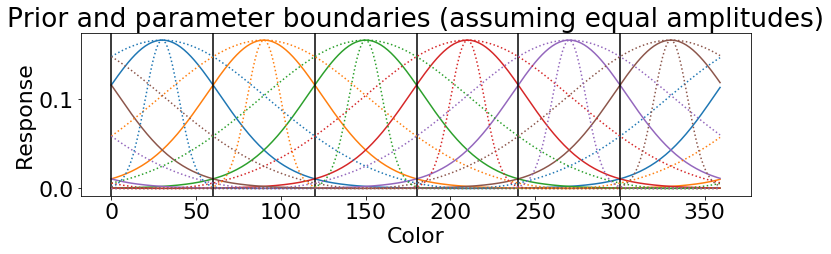

In [182]:
# Plot prior and parameter bounds
# Plot prior averages
vox_mu_basis_r = np.linspace(0,360-(360/nchannels),nchannels)+30
channel_sd_r = np.ones(nchannels)*40
vox_amp_basis_r = [np.mean(prior['p'][:,chan+1]) for chan in range(nchannels)]
vox_amp_basis_r = sumfix(np.ones(nchannels))
plt.plot(make_vonmises_iter(np.linspace(0,359,360),vox_mu_basis_r,channel_sd_r,vox_amp_basis_r))
plt.title('Prior and parameter boundaries (assuming equal amplitudes)') 
plt.ylabel('Response')
plt.xlabel('Color')
# plot vertical mu bounds
for chan in range(nchannels):
    plt.axvline(360/nchannels*chan,color='k')
channel_sd_r = np.ones(nchannels)*90
basis = make_vonmises_iter(np.linspace(0,359,360),vox_mu_basis_r,channel_sd_r,vox_amp_basis_r)
# plot sd bounds
plt.gca().set_prop_cycle(None) # reset default matplotlib color picker
for chan in np.arange(nchannels):
    plt.plot(basis[:,chan],':')
channel_sd_r = np.ones(nchannels)*10
basis = make_vonmises_iter(np.linspace(0,359,360),vox_mu_basis_r,channel_sd_r,vox_amp_basis_r)
plt.gca().set_prop_cycle(None) # reset default matplotlib color picker
for chan in np.arange(nchannels):
    plt.plot(basis[:,chan],':')
plt.show()

### Posterior

In [262]:
# del posterior
with shared_k_6_channels:   
    
    ## MCMC (NUTS) ##
    # note: running complicated models with MCMC will likely lead to
    # ridiculously long sampling times, lack of convergence, or stalling
    # in this case, VI may be preferable because
    # (1) VI takes much less time to run (although does not guarantee solution, 
    # but, practically speaking, neither does MCMC)
    # (2) VI might produce better fit than MCMC because data is too complex for MCMC (i.e., doesn't converge)
    posterior = pm.sample(1000, tune=1000, chains=3)
#     pm.save_trace(posterior,"posterior_mcmc",overwrite=True)
    
    ## Variational inference ##
#     approx = pm.FullRankADVI()
#     approx.fit(100000)
#     approx.refine(900000) # if you want to keep sampling
# saveparam = [(param.name, param.eval()) for param in posterior.params]

#     posterior = modelfit.sample(1000)
#     save_obj(posterior, "shared_k_1_channels")
# #     pm.save_trace(modelfit,"shared_k_1_channels",overwrite=True)

#     # save inference
#     bij = posterior.approx.groups[0].bij
#     saveparam = {param.name: bij.rmap(param.eval())
#          for param in inference.approx.params}
 
#     # load inference
#     bij2 = inference2.approx.groups[0].bij
#     inference2.approx.params[0].set_value(bij2.map(saveparam['mu']))
#     inference2.approx.params[1].set_value(bij2.map(saveparam['rho']))

# pm.summary(posterior,include_circ=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 2 jobs)
NUTS: [p, mu_5, mu_4, mu_3, mu_2, mu_1, mu_0, kappa]
Sampling 3 chains: 100%|██████████| 6000/6000 [18:36<00:00,  5.37draws/s]
The acceptance probability does not match the target. It is 0.7214173258540468, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8859605647547775, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


## Checking/validating the model

We can summarize all the results using the pm.summary() command. Feel free to examine the parameters and see what the 95% HDI (highest density interval aka HPD or highest posterior density) is. 95% HDIs indicate that the true parameter value has a 95% probability of lying within this interval. Values outside the intervals may be considered sufficiently implausible to be untenable (Lindley, 1965). 

In [263]:
pm.summary(posterior,include_circ=True)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
kappa,6.095081,0.659735,0.029661,4.876988,7.279998,393.968814,1.003270
mu_0,-2.280281,0.132668,0.005069,-2.493072,-2.094777,737.293764,0.999778
mu_1,-1.892296,0.156252,0.005427,-2.094371,-1.621051,779.893785,1.000124
mu_2,-0.629406,0.059174,0.001384,-0.744663,-0.511014,1620.913519,0.999934
mu_3,0.763331,0.087933,0.003512,0.594767,0.955771,502.828315,1.003555
mu_4,1.270717,0.104873,0.003265,1.061005,1.425792,741.503546,1.009654
mu_5,2.517539,0.026750,0.000668,2.462819,2.568864,1370.982612,0.999521
p__0,0.174814,0.080595,0.003018,0.024555,0.323132,691.796295,0.999950
p__1,0.159495,0.080138,0.003009,0.011009,0.308014,683.767374,1.000040
p__2,0.056795,0.004557,0.000098,0.047421,0.065320,2084.320662,1.000962


In [47]:
# posterior = approx.approx.sample(2000)
pm.summary(posterior,include_circ=True)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mua,0.017403,0.004324,0.000048,0.008631,0.025560,8264.457163,0.999764
mub,-3.122792,0.093534,0.001388,-3.134871,-3.114385,4508.839871,0.999974
kappas,9.744692,0.139764,0.001551,9.473208,10.017277,8569.465579,0.999953
p__0,0.593441,0.004909,0.000051,0.583337,0.602424,7451.950947,0.999859
p__1,0.406559,0.004909,0.000051,0.397576,0.416663,7451.950947,0.999859


In [216]:
pm.summary(posterior,include_circ=True) # no noise

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu_0,-1.686135,0.838515,0.082976,-2.907970,-1.047267,1.502115,32.045790
mu_1,-0.770660,0.076390,0.007211,-0.881701,-0.674902,1.641203,3.618057
mu_2,2.494311,0.900053,0.089549,1.211139,3.141592,1.500749,82.057249
kappa_0,26.472470,3.287545,0.174802,21.383479,33.111604,214.973574,1.022338
kappa_1,18.399905,4.441683,0.400119,12.052882,24.928710,1.771814,2.674380
kappa_2,22.792421,6.345166,0.611296,15.622646,33.327701,1.564298,5.092823
p__0,0.410876,0.011554,0.000890,0.386912,0.430464,2.273611,1.768073
p__1,0.155893,0.061841,0.005420,0.063856,0.246993,1.929870,2.242701
p__2,0.345546,0.098760,0.009358,0.225812,0.489857,1.632033,3.736961
p__3,0.087685,0.033655,0.003279,0.027440,0.124018,1.571435,5.065426


In [82]:
pm.summary(posterior,include_circ=True) #noise=2

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu_0,-2.972030,0.079637,0.003178,-3.084944,-2.853343,605.788467,1.001898
mu_1,-1.835209,0.031203,0.000519,-1.897404,-1.774974,2675.128455,1.000411
mu_2,-0.648819,0.045445,0.000990,-0.737963,-0.559078,1837.913056,1.001299
mu_3,0.768427,0.104900,0.002549,0.596793,0.960304,1258.308524,0.999944
mu_4,1.299126,0.199807,0.004406,1.047268,1.724778,1427.357892,1.000496
mu_5,2.535030,0.110020,0.003827,2.357686,2.752170,811.285774,1.001638
kappa_0,10.355157,4.906041,0.118990,1.312256,19.478106,1510.305954,1.001397
kappa_1,8.919465,3.038424,0.104760,4.221556,14.833232,803.999824,1.003521
kappa_2,3.940936,0.979554,0.024630,2.049192,5.737159,1323.281805,1.000787
kappa_3,12.176708,7.039498,0.160334,3.114569,26.965552,1368.348923,1.000247


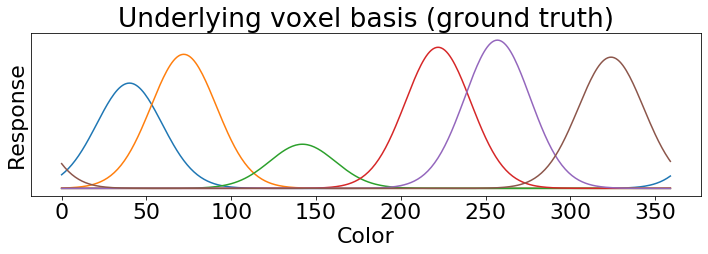

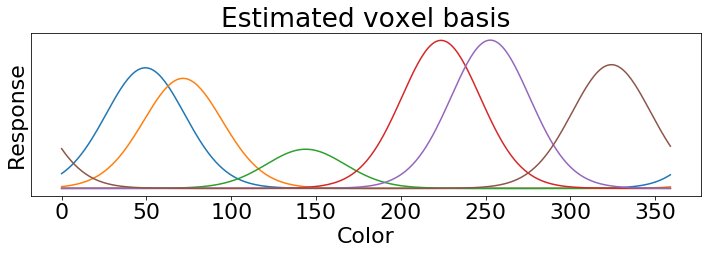

In [264]:
# Plot simulated voxel tunings (ground truth)               
plt.plot(make_vonmises_iter(np.linspace(0,359,360),vox_mu_basis,channel_sd,vox_amp_basis))
plt.title('Underlying voxel basis (ground truth)') 
plt.ylabel('Response'); plt.yticks([])
plt.xlabel('Color')
plt.show()

# Plot estimated voxel tunings
vox_mu_basis_r = [np.mean(posterior['mu_deg_{}'.format(chan)]) for chan in range(nchannels)]
channel_sd_r = np.mean(posterior['sd_deg'])*np.ones(nchannels)
vox_amp_basis_r = [np.mean(posterior['p'][:,chan]) for chan in range(nchannels)]
vox_amp_basis_r = sumfix(vox_amp_basis_r)
plt.plot(make_vonmises_iter(np.linspace(0,359,360),vox_mu_basis_r,np.ones(nchannels)*channel_sd_r,vox_amp_basis_r))
plt.title('Estimated voxel basis') 
plt.ylabel('Response'); plt.yticks([])
plt.xlabel('Color')
plt.show()

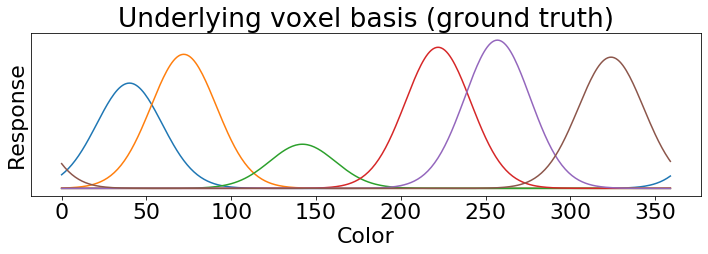

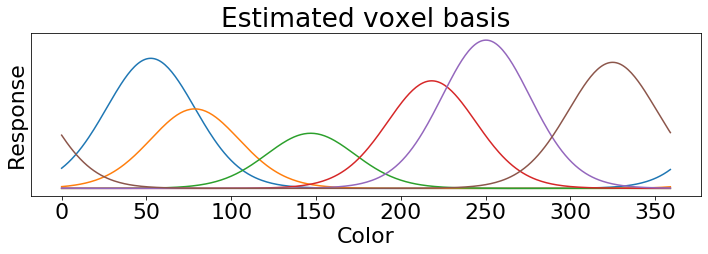

In [230]:
# Plot simulated voxel tunings (ground truth)               
plt.plot(make_vonmises_iter(np.linspace(0,359,360),vox_mu_basis,channel_sd,vox_amp_basis))
plt.title('Underlying voxel basis (ground truth)') 
plt.ylabel('Response'); plt.yticks([])
plt.xlabel('Color')
plt.show()

# Plot estimated voxel tunings
vox_mu_basis_r = [np.mean(posterior['mu_deg_{}'.format(chan)]) for chan in range(nchannels)]
channel_sd_r = np.mean(posterior['sd_deg'])*np.ones(nchannels)
vox_amp_basis_r = [np.mean(posterior['p'][:,chan]) for chan in range(nchannels)]
vox_amp_basis_r = sumfix(vox_amp_basis_r)
plt.plot(make_vonmises_iter(np.linspace(0,359,360),vox_mu_basis_r,np.ones(nchannels)*channel_sd_r,vox_amp_basis_r))
plt.title('Estimated voxel basis') 
plt.ylabel('Response'); plt.yticks([])
plt.xlabel('Color')
plt.show()

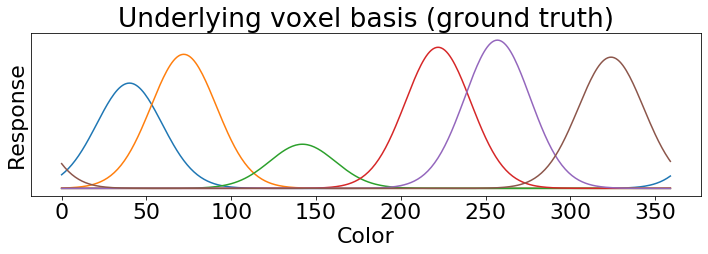

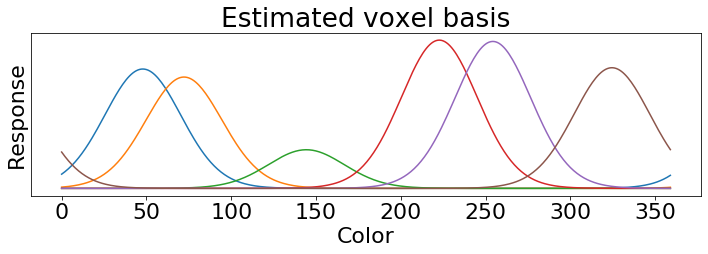

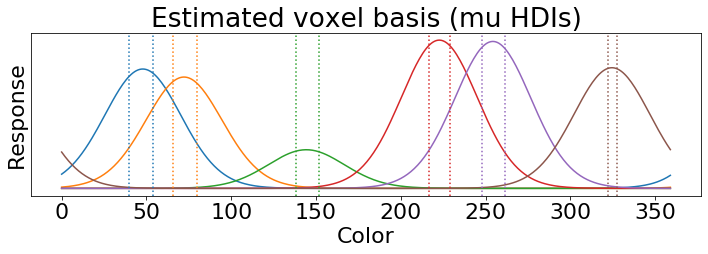

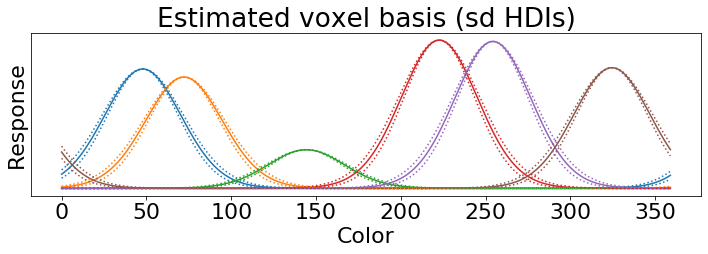

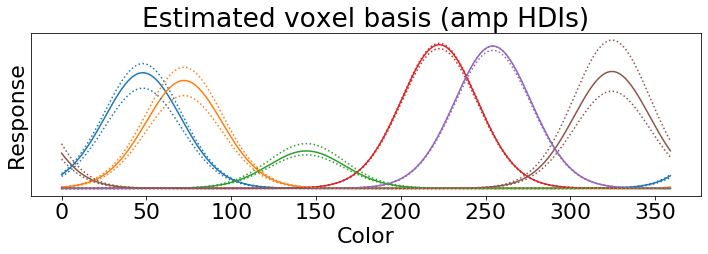

In [254]:
# Plot simulated voxel tunings (ground truth)               
plt.plot(make_vonmises_iter(np.linspace(0,359,360),vox_mu_basis,channel_sd,vox_amp_basis))
plt.title('Underlying voxel basis (ground truth)') 
plt.ylabel('Response'); plt.yticks([])
plt.xlabel('Color')
plt.show()


# Plot estimated voxel tunings
vox_mu_basis_r = [np.mean(posterior['mu_deg_{}'.format(chan)]) for chan in range(nchannels)]
# channel_sd_r = [np.mean(posterior['sd_deg_{}'.format(chan)]) for chan in range(nchannels)]
channel_sd_r = np.mean(posterior['sd_deg'])*np.ones(nchannels)
vox_amp_basis_r = [np.mean(posterior['p'][:,chan]) for chan in range(nchannels)]
vox_amp_basis_r = sumfix(vox_amp_basis_r)
plt.plot(make_vonmises_iter(np.linspace(0,359,360),vox_mu_basis_r,channel_sd_r,vox_amp_basis_r))
plt.title('Estimated voxel basis') 
plt.ylabel('Response'); plt.yticks([])
plt.xlabel('Color')
plt.show()

## PLOTTING HDIS ##

# Plot estimated voxel tunings
vox_mu_basis_r = [np.mean(posterior['mu_deg_{}'.format(chan)]) for chan in range(nchannels)]
vox_amp_basis_r = [np.mean(posterior['p'][:,chan]) for chan in range(nchannels)]
vox_amp_basis_r = sumfix(vox_amp_basis_r)
plt.plot(make_vonmises_iter(np.linspace(0,359,360),vox_mu_basis_r,channel_sd_r,vox_amp_basis_r))
plt.title('Estimated voxel basis (mu HDIs)') 
plt.ylabel('Response'); plt.yticks([])
plt.xlabel('Color')
# plot mu HDI intervals
vox_mu_basis_r0 = [pm.stats.hpd(posterior['mu_deg_{}'.format(chan)])[0] for chan in range(nchannels)]
vox_mu_basis_r1 = [pm.stats.hpd(posterior['mu_deg_{}'.format(chan)])[1] for chan in range(nchannels)]
colors=plt.rcParams['axes.prop_cycle'].by_key()['color']
for chan in range(nchannels):
    plt.axvline(vox_mu_basis_r0[chan],linestyle=':',color=colors[chan])
    plt.axvline(vox_mu_basis_r1[chan],linestyle=':',color=colors[chan])
plt.show()
    
# Plot simulated voxel tunings (ground truth)               
vox_mu_basis_r = [np.mean(posterior['mu_deg_{}'.format(chan)]) for chan in range(nchannels)]
vox_amp_basis_r = [np.mean(posterior['p'][:,chan]) for chan in range(nchannels)]
vox_amp_basis_r = sumfix(vox_amp_basis_r)
plt.plot(make_vonmises_iter(np.linspace(0,359,360),vox_mu_basis_r,channel_sd_r,vox_amp_basis_r))
plt.title('Estimated voxel basis (sd HDIs)') 
plt.ylabel('Response'); plt.yticks([])
plt.xlabel('Color')
# plot sd HDI intervals
# channel_sd_r = [pm.stats.hpd(posterior['sd_deg_{}'.format(chan)])[0] for chan in range(nchannels)]
channel_sd_r = pm.stats.hpd(posterior['sd_deg'])[0]*np.ones(nchannels)
basis = make_vonmises_iter(np.linspace(0,359,360),vox_mu_basis_r,channel_sd_r,vox_amp_basis_r)
plt.gca().set_prop_cycle(None) # reset default matplotlib color picker
for chan in np.arange(nchannels):
    plt.plot(basis[:,chan],':')
channel_sd_r = pm.stats.hpd(posterior['sd_deg'])[1]*np.ones(nchannels)
basis = make_vonmises_iter(np.linspace(0,359,360),vox_mu_basis_r,channel_sd_r,vox_amp_basis_r)
plt.gca().set_prop_cycle(None) # reset default matplotlib color picker
for chan in np.arange(nchannels):
    plt.plot(basis[:,chan],':')
plt.show()

# Plot simulated voxel tunings (ground truth)               
vox_mu_basis_r = [np.mean(posterior['mu_deg_{}'.format(chan)]) for chan in range(nchannels)]
channel_sd_r = np.mean(posterior['sd_deg'])*np.ones(nchannels)
vox_amp_basis_r = [np.mean(posterior['p'][:,chan]) for chan in range(nchannels)]
vox_amp_basis_r = sumfix(vox_amp_basis_r)
plt.plot(make_vonmises_iter(np.linspace(0,359,360),vox_mu_basis_r,channel_sd_r,vox_amp_basis_r))
plt.title('Estimated voxel basis (amp HDIs)') 
plt.ylabel('Response'); plt.yticks([])
plt.xlabel('Color')
# plot amp HDI intervals 
vox_amp_basis_r = sumfix(pm.stats.hpd(posterior['p'])[:,0])
basis = make_vonmises_iter(np.linspace(0,359,360),vox_mu_basis_r,channel_sd_r,vox_amp_basis_r)
plt.gca().set_prop_cycle(None) # reset default matplotlib color picker
for chan in np.arange(nchannels):
    plt.plot(basis[:,chan],':')
vox_amp_basis_r = sumfix(pm.stats.hpd(posterior['p'])[:,1])
basis = make_vonmises_iter(np.linspace(0,359,360),vox_mu_basis_r,channel_sd_r,vox_amp_basis_r)
plt.gca().set_prop_cycle(None) # reset default matplotlib color picker
for chan in np.arange(nchannels):
    plt.plot(basis[:,chan],':')
plt.show()

### Trace plots
Trace plots show the history of sampling for each Markov chain. Good to visually see that chains never got stuck, never explored weird divergences, and don't show high serial correlation (i.e., effective sample size is too low such that chains were slow to explore and show few independent observations).

INFO (theano.gof.compilelock): Refreshing lock /Users/scotti.5/.theano/compiledir_Darwin-17.7.0-x86_64-i386-64bit-i386-3.7.3-64/lock_dir/lock


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c3d58b358>,
      dtype=object)

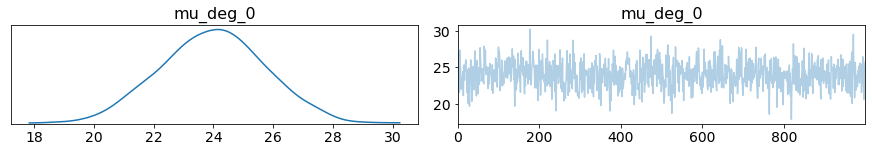

In [570]:
pm.traceplot(posterior,var_names=["mu_deg_0"])

### Gelman-Rubin diagnostic (MCMC only)

Tests for lack of convergence by comparing the variance between multiple chains to the variance within each chain. If convergence has been achieved, the between-chain and within-chain variances should be identical. Gelman et al. (2004) recommend R to be less than 1.1. You also get this output using pm.summary().

Gelman, A., Carlin, J. B., Stern, H. S., and Rubin, D. B. (2004). Bayesian Data
Analysis. Chapman & Hall/CRC, Boca Raton, FL,.

In [ ]:
pm.diagnostics.gelman_rubin(posterior,var_names=["mu_deg_0"])

### Geweke diagnostic

Return z-scores for convergence diagnostics. Compare the mean of the first % of series with the mean of the last % of series. x is divided into a number of segments for which this difference is computed. If the series is converged, this score should oscillate between -1 and 1. If say, the first 10% of the plot is significantly different from the rest of the plot, this might indicate a longer burn-in is necessary. If adequate mixing is not observed, we could try doing burn-in (e.g., posterior = posterior[500:]) to discard the first half of all samples across chains, or refine the model.

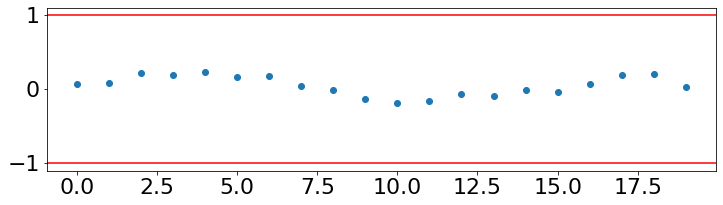

In [572]:
plt.plot(pm.geweke(posterior['mu_deg_0'])[:,1], 'o')
plt.axhline(1, c='red'); _ = plt.axhline(-1, c='red')
plt.gca().margins(0.05)

### Overlaying posterior over the prior

It's very helpful to better understand your prior by plotting it alongside your posterior. It allows you to see how the sampler went from a diffuse, moderately informed prior to a confident, peaky posterior distribution.

In [ ]:
# load prior directly without running model
prior = load_obj('prior')

In [100]:
sns.distplot(prior['mu_deg_0'], label='Prior', hist=False)
ax = sns.distplot(posterior['mu_deg_0'], label='Posterior', hist=False)
ax.legend()

NameError: name 'prior' is not defined

### Posterior predictive check

The idea behind posterior predictive checks is to generate data from the model using parameters from draws from the posterior. The posterior distribution should be approximating the underlying distribution (i.e., the raw observations that were input into the model). post_pred contains a dataset generated in this fashion (in blue), compared to the input data (aggregate degrees of error histogram, in red).

For more information see https://docs.pymc.io/notebooks/posterior_predictive.html

In [ ]:
# load posterior predictive directly instead of running model
post_pred = load_obj('post_pred')

In [265]:
with shared_k_6_channels:
    post_pred = pm.sample_posterior_predictive(posterior, var_names = ['y'], samples=1)
    print(post_pred['y'].shape)
    

  0%|          | 0/1 [00:26<?, ?it/s]


KeyError: 'y'

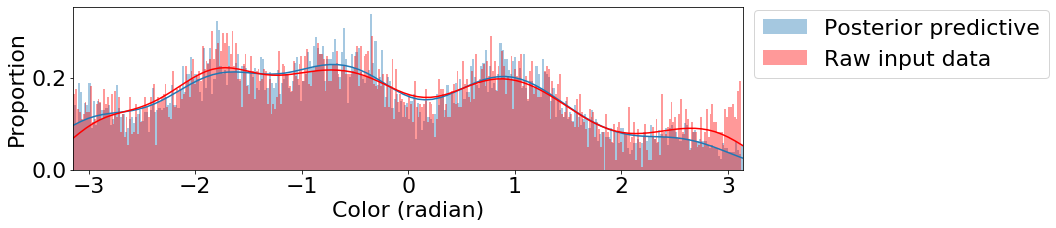

In [99]:
ax_data = sns.distplot(post_pred['y'][0,:], bins=len(np.unique(obs)), label='Posterior predictive')
ax_ppc = sns.distplot(obs, bins=len(np.unique(obs)), label='Raw input data', color='red')
ax_ppc.set_xlim(-np.pi, np.pi)
ax_ppc.set(xlabel="Color (radian)", ylabel="Proportion")
ax_ppc.legend(bbox_to_anchor=(1, 1.05))
plt.show()


## Model comparison

What if we don't know whether a 6- or 7-channel encoding model produces the best fit? We can estimate how well each model fits the data while penalizing complexity using the measures of WAIC and PSIS-LOO.

WAIC (Watanabe 2010) is a fully Bayesian criterion for estimating out-of-sample expectation, using the computed log pointwise posterior predictive density (LPPD) and correcting for the effective number of parameters to adjust for overfitting.

LOO cross-validation is an estimate of the out-of-sample predictive fit. In cross-validation, the data are repeatedly partitioned into training and holdout sets, iteratively fitting the model with the former and evaluating the fit with the holdout data. Vehtari et al. (2016) introduced an efficient computation of LOO from MCMC samples, which are corrected using Pareto-smoothed importance sampling (PSIS) to provide an estimate of point-wise out-of-sample prediction accuracy.

In [359]:
# load posteriors without running models
posteriorA = pm.load_trace("/six_channels_shared_kappa",posterior)
posteriorB = pm.load_trace("/shared_k_1_channels",shared_k_1_channels)

In [360]:
# six_channels_shared_kappa.name = "six_channels_shared_kappa"
# shared_k_1_channels.name = "shared_k_1_channels"

waic_results = pm.compare({six_channels_shared_kappa: posteriorA, 
            shared_k_1_channels: posteriorB})

loo_results = pm.compare({six_channels_shared_kappa: posteriorA, 
            shared_k_1_channels: posteriorB}, ic="LOO")

ValueError: need at least one array to stack

In [ ]:
display(waic_results)
display(loo_results)
pm.compareplot(waic_results)
pm.compareplot(loo_results)

Above is a summary plot of WAIC and LOO results. Empty circle: WAIC/LOO value, where lower value indicates better fit. Black error bars are standard deviation. Vertical dashed line indicates lowest WAIC/LOO value of the possible models. Filled black dots are the in-sample deviance of each model. Gray triangle indicates the WAIC/LOO difference between the model and the best-fitting model, with gray error bar denoting standard error of the difference in WAIC/LOO values.

In other words, the gray error bar approximates the uncertainty of WAIC/LOO estimates. If the gray error bar does not overlap with the vertical dotted line (the best-fit model estimate), then this demonstrates that the model with the lowest WAIC/LOO estimate is the best-fitting model.

Note that in the WAIC table, if var_warn = 1, this occurs if posterior variance of the log predictive densities exceeds 0.4 and suggests unreliable WAIC estimates (Vehtari, Gelman, & Gabry, 2016). Similarly, for the LOO table, shape_warn will equal 1 if the pareto distribution is greater than 0.7 for one or more samples, and this would also suggest unreliable estimates. 

# Inverted Encoding Model
## Create Forward Model & Design Matrix

In [ ]:
def try_recon(basis_points,channel_sd,trial_features):
    basis_points = correct_basis(basis_points,nchannels)
    basis_set = make_vonmises_iter(feature_space, basis_points, channel_sd) 
#     trial_weights = basis_set[trial_features,:]
    trial_weights = [basis_set[t,:][np.argmax(basis_set[t,:])] for t in trial_features]
    trial_weights = trial_weights - np.abs(np.min(trial_weights))
    return trial_weights

def auto_recon(basis_points,channel_sd,trial_features,trial_by_vox):   
    # create each basis channel
    basis_points = correct_basis(basis_points,nchannels)
    basis_set = make_vonmises_iter(feature_space, basis_points, channel_sd) 
    trial_weights = basis_set[trial_features,:]
    trial_weights = trial_weights / np.sum(trial_weights)

    X = np.linspace(0,ntrials-1,ntrials)
    train_index = list(map(int,np.sort(X[:len(X)//2])))
    test_index = list(map(int,np.sort(X[len(X)//2:])))

    saved_weights = np.linalg.lstsq(trial_weights[train_index,:], trial_by_vox[train_index,:], rcond=None)[0] 
    # solution of trial_weights @ w = trn; this is an exact solution if trial_weights is full rank

    # Invert to compute channel responses
    cr_tst = np.linalg.lstsq(saved_weights.T , trial_by_vox[test_index,:].T, rcond=None)[0].T

    # Avg. reconstructions (testing)
    trial_actual = trial_features[test_index]
    trial_guess = basis_points[np.argmax(cr_tst,axis=1)]
    trial_conf = np.max(cr_tst,axis=1)
#     trial_conf = (np.max(cr_tst,axis=1) - np.min(np.max(cr_tst,axis=1))) / (np.max(np.max(cr_tst,axis=1)) - np.min(np.max(cr_tst,axis=1)))
#     trial_guess = basis_points[[int(np.random.choice(np.linspace(0,nchannels-1,nchannels),p=cr_tst[t,:]/np.sum(cr_tst[t,:]))) for t in range(ntrials//2)]]
    trial_diff = within180(trial_actual-trial_guess)
#     trial_diff[trial_diff>(nchannels//2)] = nchannels - trial_diff[trial_diff>(nchannels//2)]
    tst_rmse = np.sqrt(np.mean((trial_diff*trial_conf)**2))
    
    # Plot simulated voxel tunings:              
    ground_truth_set = make_vonmises_iter(np.linspace(0,359,360),vox_mu_basis,np.ones(nchannels)*vox_sd_mu,vox_amp_basis)
    plt.plot(ground_truth_set/np.max(ground_truth_set))
    plt.ylabel('Response')
    plt.xlabel('Color')
    plt.yticks([])
    # Plot reconstructed basis sets:
    r_amps = np.full((nvoxels,2),np.nan)
    for vox in range(nvoxels):
        chan = np.argmin(np.abs(np.subtract.outer(np.concatenate([basis_points,[basis_points[0]+360]]), sp.stats.circmean(trial_features[np.argsort(trial_by_vox[:,vox])[-30:]],low=0,high=359))),axis=0)
        if chan >= nchannels:
            chan = 0
        r_amps[vox,:] = chan,np.max(trial_by_vox[np.isin(trial_features,np.where(basis_set[:,chan]>np.max(basis_set[:,chan])/2)),vox])
    recon_amps = []
    for chan in range(nchannels):
        recon_amps.append(np.mean(r_amps[:,1][r_amps[:,0]==chan]))
    plt.gca().set_prop_cycle(None) # reset default matplotlib color picker
    r_basis_set = make_vonmises_iter(feature_space, basis_points, channel_sd, recon_amps)
    plt.plot(r_basis_set/np.max(r_basis_set),':',linewidth=5,alpha=.5)
    plt.show()
    # Plot actual voxel tunings
    for vox in np.arange(nvoxels):
        if vox <= 50:
            plt.scatter(trial_features,trial_by_vox[:,vox])
    plt.xlabel('Color')
    plt.ylabel('Response')
    plt.yticks([])
    plt.title('First 50 Voxel Responses')
    plt.show()
    print(tst_rmse)
    print(np.mean(trial_diff))
    
    return tst_rmse

def auto_recon_old(basis_points,channel_sd,trial_features,trial_by_vox,n_splits=2):   
    # create each basis channel
    basis_set = make_vonmises(feature_space, basis_points, channel_sd)
    trial_weights = basis_set[trial_features,:]
    
    cv_iter = -1
    for n in range(n_splits):
        X = np.linspace(0,ntrials-1,np.sum(ntrials))
        train_index = list(map(int,np.sort(X[:len(X)//2])))
        test_index = list(map(int,np.sort(X[len(X)//2:])))

        if cv_iter == -1:
            tstf=[];
            cr_tst = np.full((n_splits,len(test_index),nchannels),np.nan)
        cv_iter = cv_iter + 1

        tstf.append(trial_features[test_index])
        trn_or_tst = np.zeros(len(trial_features))
        trn_or_tst[test_index] = 1

        saved_weights = np.linalg.lstsq(trial_weights[trn_or_tst==0,:], trial_by_vox[train_index,:], rcond=None)[0] 
        # solution of trial_weights @ w = trn; this is an exact solution if trial_weights is full rank

        # Invert to compute channel responses
        cr_tst[cv_iter,:,:] = np.linalg.lstsq(saved_weights.T , trial_by_vox[test_index,:].T, rcond=None)[0].T

    # collapse folds
    tstf = np.array(tstf).flatten()
    cr_tst = cr_tst.reshape(cr_tst.shape[1]*n_splits,nchannels)
    #full_saved_weights = np.linalg.lstsq(trial_weights, trial_by_vox, rcond=None)[0] 

    # Plot perfect reconstruction for comparison
    shiftby = nchannels//2
    perfect_recon = trial_weights[np.where(trial_features==shiftby*(360/nchannels))[0][0],:]

    # Avg. reconstructions (testing)
    cr_center_tst = np.empty_like(cr_tst)
    trial_actual = np.full(cr_tst.shape[0],999)
    trial_guess = np.full(cr_tst.shape[0],999)
    for trial in np.arange(cr_tst.shape[0]):
        trial_actual[trial] = np.argmin(np.abs(within180(basis_points - tstf[trial])))
        trial_guess[trial] = np.argmax(cr_tst[trial,:])
        cr_center_tst[trial,:] = np.roll( cr_tst[trial,:], shiftby - trial_actual[trial]);
    trial_diff = np.abs(trial_actual-trial_guess)
    trial_diff[trial_diff>(nchannels//2)] = nchannels - trial_diff[trial_diff>(nchannels//2)]
    trial_diff = perfect_recon[shiftby]-np.roll(perfect_recon,shiftby)[trial_diff]
    tst_mae = np.mean(trial_diff)

    return tst_mae

def auto_recon_plotting(basis_points,channel_sd,trial_features,trial_by_vox,n_splits=2):   
    # create each basis channel
    basis_points = correct_basis(basis_points,nchannels)
    basis_set = make_vonmises(feature_space, basis_points, channel_sd)
    trial_weights = basis_set[trial_features,:]
    
    cv_iter = -1
    for n in range(n_splits):
        X = np.linspace(0,ntrials-1,np.sum(ntrials))
        train_index = list(map(int,np.sort(X[:len(X)//2])))
        test_index = list(map(int,np.sort(X[len(X)//2:])))

        if cv_iter == -1:
            trn=[];tst=[];trnf=[];tstf=[];
            cr_trn = np.full((n_splits,len(train_index),nchannels),np.nan)
            cr_tst = np.full((n_splits,len(test_index),nchannels),np.nan)
        cv_iter = cv_iter + 1

        trnf.append(trial_features[train_index])
        tstf.append(trial_features[test_index])
        trn_or_tst = np.zeros(len(trial_features))
        trn_or_tst[test_index] = 1

        saved_weights = np.linalg.lstsq(trial_weights[trn_or_tst==0,:], trial_by_vox[train_index,:], rcond=None)[0] 
        # solution of trial_weights @ w = trn; this is an exact solution if trial_weights is full rank

        # Invert to compute channel responses
        cr_trn[cv_iter,:,:] = np.linalg.lstsq(saved_weights.T , trial_by_vox[train_index,:].T, rcond=None)[0].T
        cr_tst[cv_iter,:,:] = np.linalg.lstsq(saved_weights.T , trial_by_vox[test_index,:].T, rcond=None)[0].T

    # collapse folds
    trnf = np.array(trnf).flatten()
    tstf = np.array(tstf).flatten()
    cr_trn = cr_trn.reshape(cr_trn.shape[1]*n_splits,nchannels)
    cr_tst = cr_tst.reshape(cr_tst.shape[1]*n_splits,nchannels)
    #full_saved_weights = np.linalg.lstsq(trial_weights, trial_by_vox, rcond=None)[0] 

    # Plot perfect reconstruction for comparison
    shiftby = nchannels//2
            
    # Avg. reconstructions (training)
    cr_center_trn = np.empty_like(cr_trn)
    trial_actual = np.full(cr_trn.shape[0],999)
    trial_guess = np.full(cr_trn.shape[0],999)
    trial_actual = basis_features(basis_points,trnf)
    for trial in np.arange(cr_trn.shape[0]):
        trial_guess[trial] = np.argmax(cr_trn[trial,:])
        cr_center_trn[trial,:] = np.roll( cr_trn[trial,:], shiftby - trial_actual[trial]);
    trial_diff = np.abs(trial_actual-trial_guess)
    trial_diff[trial_diff>(nchannels//2)] = nchannels - trial_diff[trial_diff>(nchannels//2)]
#     trial_diff = perfect_recon[shiftby]-np.roll(perfect_recon,shiftby)[trial_diff]
    trn_mae = np.mean(trial_diff)

    # Avg. reconstructions (testing)
    cr_center_tst = np.empty_like(cr_tst)
    trial_actual = np.full(cr_tst.shape[0],999)
    trial_guess = np.full(cr_tst.shape[0],999)
    trial_actual = basis_features(basis_points,tstf)
    for trial in np.arange(cr_tst.shape[0]):
        trial_guess[trial] = np.argmax(cr_tst[trial,:])
        cr_center_tst[trial,:] = np.roll( cr_tst[trial,:], shiftby - trial_actual[trial]);
    trial_diff = np.abs(trial_actual-trial_guess)
    trial_diff[trial_diff>(nchannels//2)] = nchannels - trial_diff[trial_diff>(nchannels//2)]
#     trial_diff = perfect_recon[shiftby]-np.roll(perfect_recon,shiftby)[trial_diff]
    tst_mae = np.mean(trial_diff)

    # Null distribution testing
    numperms = 1000
    cr_center_null = np.empty_like(cr_tst)
    trial_actual = np.full(cr_tst.shape[0],999)
    trial_guess = np.full(cr_tst.shape[0],999)
    null_mae = np.full(numperms,np.nan)
    for perm in np.arange(numperms):
        tstf_shuffle = np.random.permutation(tstf)
        trial_actual = basis_features(basis_points,tstf_shuffle)
        for trial in np.arange(cr_tst.shape[0]):
            trial_guess[trial] = np.argmax(cr_tst[trial,:])
            cr_center_null[trial,:] = np.roll( cr_tst[trial,:], shiftby - trial_actual[trial]);
        trial_diff = np.abs(trial_actual-trial_guess)
        trial_diff[trial_diff>(nchannels//2)] = nchannels - trial_diff[trial_diff>(nchannels//2)]
#         trial_diff = perfect_recon[shiftby]-np.roll(perfect_recon,shiftby)[trial_diff]
        null_mae[perm] = np.mean(trial_diff)

    trn_overlap = len(null_mae[null_mae<trn_mae])/len(null_mae)*100
    tst_overlap = len(null_mae[null_mae<tst_mae])/len(null_mae)*100

    # Plotting
    print("train: avg MAE: {}".format(trn_mae))
    plt.plot(np.mean(cr_center_tst,axis=0),color='r')
    plt.title("Test")
    plt.xlabel("Color")
    plt.ylabel("Channel Response")
    plt.show()    
    plt.plot(np.mean(cr_center_trn,axis=0),color='b',label="Train")
    plt.plot(np.mean(cr_center_tst,axis=0),color='r',label="Test")
    plt.plot(np.mean(cr_center_null,axis=0),color='gray',label="Null")
    plt.title("All Reconstructions (overlaid)")
    plt.xlabel("Color")
    plt.ylabel("Channel Response")
    plt.legend()
    plt.show()
    print("test: avg MAE: {}".format(tst_mae))
    sns.distplot(null_mae,color='gray',bins=10)
    plt.axvline(trn_mae,color='blue',label="Train MAE")
    plt.axvline(tst_mae,color='red',label="Test MAE")
    plt.axvline(np.mean(null_mae),linestyle=':',color='gray',label="Null")
    plt.legend(bbox_to_anchor=(1, 1.05))
    plt.text(trn_mae,1,"{:.2f}%".format(trn_overlap),color='blue')
    plt.text(tst_mae,.25,"{:.2f}%".format(tst_overlap),color='red')
    plt.xlim([0,2])
    plt.show()
    print("null: avg MAE: {}".format(np.mean(null_mae)))
    print("% overlap w/ null distribution ({} permutations): {}%".format(numperms,tst_overlap))
    print("basically, this means p={:.3f}".format(tst_overlap/100))
    if tst_overlap < 5:
        print("meaning that test reconstructions are significantly different from null reconstructions.")
    else:
        print("meaning that test reconstructions are not significantly different from null reconstructions.")
    # Plot simulated voxel tunings:              
    ground_truth_set = make_vonmises(np.linspace(0,359,360),vox_mu_basis,np.ones(nchannels)*vox_sd_mu,vox_amp_basis)
    plt.plot(ground_truth_set/np.max(ground_truth_set))
    plt.ylabel('Response')
    plt.xlabel('Color')
    plt.yticks([])
    # Plot reconstructed basis sets:
    r_amps = np.full((nvoxels,2),np.nan)
    for vox in range(nvoxels):
        chan = np.argmin(np.abs(np.subtract.outer(np.concatenate([basis_points,[basis_points[0]+360]]), sp.stats.circmean(trial_features[np.argsort(trial_by_vox[:,vox])[-30:]],low=0,high=359))),axis=0)
        if chan >= nchannels:
            chan = 0
        #chan = np.argmin(np.abs(within180(basis_points - np.median(trial_features[np.argsort(trial_by_vox[:,vox])[-30:]]))))
        r_amps[vox,:] = chan,np.max(trial_by_vox[np.isin(trial_features,np.where(basis_set[:,chan]>np.max(basis_set[:,chan])/2)),vox])
    #r_amps[:,1] = r_amps[:,1]/np.max(r_amps[:,1])
    recon_amps = []
    for chan in range(nchannels):
        recon_amps.append(np.mean(r_amps[:,1][r_amps[:,0]==chan]))
    plt.gca().set_prop_cycle(None) # reset default matplotlib color picker
    r_basis_set = make_vonmises(feature_space, basis_points, channel_sd, recon_amps)
    plt.plot(r_basis_set/np.max(r_basis_set),':',linewidth=5,alpha=.5)
    plt.show()
    print("null mae range: {},{}".format(np.min(null_mae),np.max(null_mae)))
    print("null_mae - tst_mae (larger positive number is better): {}".format(np.mean(null_mae - tst_mae)))
    print("tst_mae - trn_mae (smaller number is better): {}".format(np.mean(tst_mae - trn_mae)))
    return tst_mae, tst_overlap

def auto_recon_plotting_old(basis_points,channel_sd,trial_features,trial_by_vox,n_splits=2):   
    # create each basis channel
    basis_points = correct_basis(basis_points,nchannels)
    basis_set = make_vonmises(feature_space, basis_points, channel_sd)
    trial_weights = basis_set[trial_features,:]
    
    cv_iter = -1
    for n in range(n_splits):
        X = np.linspace(0,ntrials-1,np.sum(ntrials))
        train_index = list(map(int,np.sort(X[:len(X)//2])))
        test_index = list(map(int,np.sort(X[len(X)//2:])))

        if cv_iter == -1:
            trn=[];tst=[];trnf=[];tstf=[];
            cr_trn = np.full((n_splits,len(train_index),nchannels),np.nan)
            cr_tst = np.full((n_splits,len(test_index),nchannels),np.nan)
        cv_iter = cv_iter + 1

        trnf.append(trial_features[train_index])
        tstf.append(trial_features[test_index])
        trn_or_tst = np.zeros(len(trial_features))
        trn_or_tst[test_index] = 1

        saved_weights = np.linalg.lstsq(trial_weights[trn_or_tst==0,:], trial_by_vox[train_index,:], rcond=None)[0] 
        # solution of trial_weights @ w = trn; this is an exact solution if trial_weights is full rank

        # Invert to compute channel responses
        cr_trn[cv_iter,:,:] = np.linalg.lstsq(saved_weights.T , trial_by_vox[train_index,:].T, rcond=None)[0].T
        cr_tst[cv_iter,:,:] = np.linalg.lstsq(saved_weights.T , trial_by_vox[test_index,:].T, rcond=None)[0].T

    # collapse folds
    trnf = np.array(trnf).flatten()
    tstf = np.array(tstf).flatten()
    cr_trn = cr_trn.reshape(cr_trn.shape[1]*n_splits,nchannels)
    cr_tst = cr_tst.reshape(cr_tst.shape[1]*n_splits,nchannels)
    #full_saved_weights = np.linalg.lstsq(trial_weights, trial_by_vox, rcond=None)[0] 

    # Plot perfect reconstruction for comparison
    shiftby = nchannels//2
    perfect_recon = basis_set[int(basis_points[shiftby]),:]
    perfect_recon = perfect_recon / np.max(perfect_recon)
    if np.argmax(perfect_recon) != shiftby:
        raise ValueError('Shiftby Error')
            
    # Avg. reconstructions (training)
    cr_center_trn = np.empty_like(cr_trn)
    trial_actual = np.full(cr_trn.shape[0],999)
    trial_guess = np.full(cr_trn.shape[0],999)
    trial_actual = basis_features(basis_points,trnf)
    for trial in np.arange(cr_trn.shape[0]):
        trial_guess[trial] = np.argmax(cr_trn[trial,:])
        cr_center_trn[trial,:] = np.roll( cr_trn[trial,:], shiftby - trial_actual[trial]);
    trial_diff = np.abs(trial_actual-trial_guess)
    trial_diff[trial_diff>(nchannels//2)] = nchannels - trial_diff[trial_diff>(nchannels//2)]
    trial_diff = perfect_recon[shiftby]-np.roll(perfect_recon,shiftby)[trial_diff]
    trn_mae = np.mean(trial_diff)

    # Avg. reconstructions (testing)
    cr_center_tst = np.empty_like(cr_tst)
    trial_actual = np.full(cr_tst.shape[0],999)
    trial_guess = np.full(cr_tst.shape[0],999)
    trial_actual = basis_features(basis_points,tstf)
    for trial in np.arange(cr_tst.shape[0]):
        trial_guess[trial] = np.argmax(cr_tst[trial,:])
        cr_center_tst[trial,:] = np.roll( cr_tst[trial,:], shiftby - trial_actual[trial]);
    trial_diff = np.abs(trial_actual-trial_guess)
    trial_diff[trial_diff>(nchannels//2)] = nchannels - trial_diff[trial_diff>(nchannels//2)]
    trial_diff = perfect_recon[shiftby]-np.roll(perfect_recon,shiftby)[trial_diff]
    tst_mae = np.mean(trial_diff)

    # Null distribution testing
    numperms = 1000
    cr_center_null = np.empty_like(cr_tst)
    trial_actual = np.full(cr_tst.shape[0],999)
    trial_guess = np.full(cr_tst.shape[0],999)
    null_mae = np.full(numperms,np.nan)
    for perm in np.arange(numperms):
        tstf_shuffle = np.random.permutation(tstf)
        trial_actual = basis_features(basis_points,tstf_shuffle)
        for trial in np.arange(cr_tst.shape[0]):
            trial_guess[trial] = np.argmax(cr_tst[trial,:])
            cr_center_null[trial,:] = np.roll( cr_tst[trial,:], shiftby - trial_actual[trial]);
        trial_diff = np.abs(trial_actual-trial_guess)
        trial_diff[trial_diff>(nchannels//2)] = nchannels - trial_diff[trial_diff>(nchannels//2)]
        trial_diff = perfect_recon[shiftby]-np.roll(perfect_recon,shiftby)[trial_diff]
        null_mae[perm] = np.mean(trial_diff)

    trn_overlap = len(null_mae[null_mae<trn_mae])/len(null_mae)*100
    tst_overlap = len(null_mae[null_mae<tst_mae])/len(null_mae)*100

    # Plotting
    print("Reconstructions aligned at {} \n".format(shiftby))
    plt.plot(perfect_recon,color='k')
    plt.title("Perfect Reconstruction (for comparison)")
    plt.xlabel("Color")
    plt.ylabel("Channel Response")
    plt.show()
    plt.plot(np.mean(cr_center_trn,axis=0),color='b')
    plt.title("Train")
    plt.xlabel("Color")
    plt.ylabel("Channel Response")
    plt.show()
    print("train: avg MAE: {}".format(trn_mae))
    plt.plot(np.mean(cr_center_tst,axis=0),color='r')
    plt.title("Test")
    plt.xlabel("Color")
    plt.ylabel("Channel Response")
    plt.show()    
    plt.plot(np.mean(cr_center_trn,axis=0),color='b',label="Train")
    plt.plot(np.mean(cr_center_tst,axis=0),color='r',label="Test")
    plt.plot(np.mean(cr_center_null,axis=0),color='gray',label="Null")
    plt.title("All Reconstructions (overlaid)")
    plt.xlabel("Color")
    plt.ylabel("Channel Response")
    plt.legend()
    plt.show()
    print("test: avg MAE: {}".format(tst_mae))
    sns.distplot(null_mae,color='gray',bins=10)
    plt.axvline(trn_mae,color='blue',label="Train MAE")
    plt.axvline(tst_mae,color='red',label="Test MAE")
    plt.axvline(np.mean(null_mae),linestyle=':',color='gray',label="Null")
    plt.legend(bbox_to_anchor=(1, 1.05))
    plt.text(trn_mae,1,"{:.2f}%".format(trn_overlap),color='blue')
    plt.text(tst_mae,.25,"{:.2f}%".format(tst_overlap),color='red')
    plt.xlim([0,1])
    plt.show()
    print("null: avg MAE: {}".format(np.mean(null_mae)))
    print("% overlap w/ null distribution ({} permutations): {}%".format(numperms,tst_overlap))
    print("basically, this means p={:.3f}".format(tst_overlap/100))
    if tst_overlap < 5:
        print("meaning that test reconstructions are significantly different from null reconstructions.")
    else:
        print("meaning that test reconstructions are not significantly different from null reconstructions.")
    # Plot simulated voxel tunings:              
    ground_truth_set = make_vonmises(np.linspace(0,359,360),vox_mu_basis,np.ones(nchannels)*vox_sd_mu,vox_amp_basis)
    plt.plot(ground_truth_set/np.max(ground_truth_set))
    plt.ylabel('Response')
    plt.xlabel('Color')
    plt.yticks([])
    # Plot reconstructed basis sets:
    r_amps = np.full((nvoxels,2),np.nan)
    for vox in range(nvoxels):
        chan = np.argmin(np.abs(np.subtract.outer(np.concatenate([basis_points,[basis_points[0]+360]]), sp.stats.circmean(trial_features[np.argsort(trial_by_vox[:,vox])[-30:]],low=0,high=359))),axis=0)
        if chan >= nchannels:
            chan = 0
        #chan = np.argmin(np.abs(within180(basis_points - np.median(trial_features[np.argsort(trial_by_vox[:,vox])[-30:]]))))
        r_amps[vox,:] = chan,np.max(trial_by_vox[np.isin(trial_features,np.where(basis_set[:,chan]>np.max(basis_set[:,chan])/2)),vox])
    #r_amps[:,1] = r_amps[:,1]/np.max(r_amps[:,1])
    recon_amps = []
    for chan in range(nchannels):
        recon_amps.append(np.mean(r_amps[:,1][r_amps[:,0]==chan]))
    plt.gca().set_prop_cycle(None) # reset default matplotlib color picker
    r_basis_set = make_vonmises(feature_space, basis_points, channel_sd, recon_amps)
    plt.plot(r_basis_set/np.max(r_basis_set),':',linewidth=5,alpha=.5)
    plt.show()
    print("null mae range: {},{}".format(np.min(null_mae),np.max(null_mae)))
    print("null_mae - tst_mae (larger positive number is better): {}".format(np.mean(null_mae - tst_mae)))
    print("tst_mae - trn_mae (smaller number is better): {}".format(np.mean(tst_mae - trn_mae)))
    return tst_mae, tst_overlap
    
def plot_basis_avg(basis_points,channel_sd,trial_features,chan_pow=np.ones(nchannels)/nchannels): 
    # reset default matplotlib color picker
    plt.gca().set_prop_cycle(None)
    
    # create each basis channel
    basis_set = make_vonmises(feature_space, basis_points, channel_sd, chan_pow)
        
    # plot basis functions
    for chan in np.arange(nchannels):
        plt.plot(basis_set[:,chan])

    plt.xlabel('Color')
    plt.ylabel('Response')
    plt.yticks([])
    plt.title("Reconstructed Basis Set",color='green') 
    
def plot_basis_dotted(basis_points,channel_sd,trial_features,chan_pow=np.ones(nchannels)/nchannels): 
    # reset default matplotlib color picker
    plt.gca().set_prop_cycle(None)
    
    # create each basis channel
    basis_set = make_vonmises(feature_space, basis_points, channel_sd, chan_pow)
        
    # plot basis functions
    for chan in np.arange(nchannels):
        plt.plot(basis_set[:,chan],':')

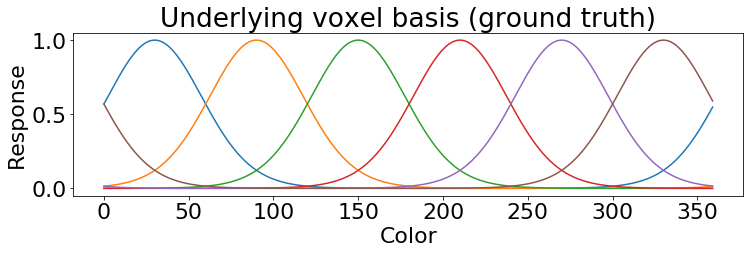

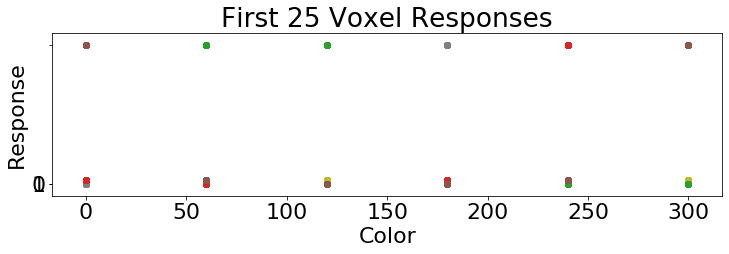

In [170]:
# Plot chosen basis set
plt.plot(make_vonmises_iter(np.linspace(0,359,360),vox_mu_basis,channel_sd,vox_amp_basis))
plt.title('Underlying voxel basis (ground truth)') 
plt.ylabel('Response')
plt.xlabel('Color')
plt.show()

# Plot actual voxel tunings:
for vox in np.arange(nvoxels):
    if vox <= 25:
        plt.scatter(trial_features,trial_by_vox[:,vox])
plt.xlabel('Color')
plt.ylabel('Response')
plt.yticks([0,np.max(trial_by_vox[:,vox])//2,np.max(trial_by_vox[:,vox])], [0,1])
plt.title('First 25 Voxel Responses')
plt.show()

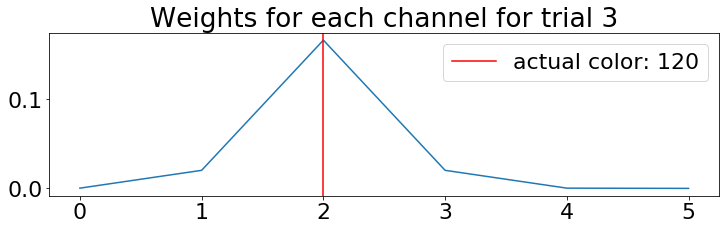

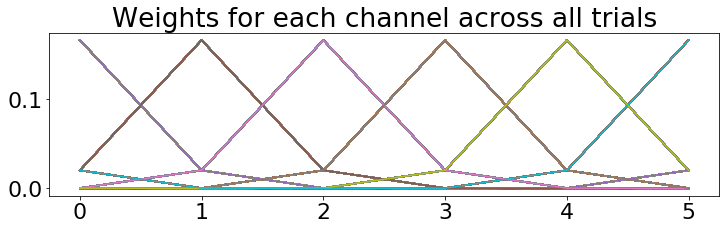

In [171]:
trial_weights = basis_set[trial_features,:]

trial = 2
plt.plot(trial_weights[trial,:])
plt.title("Weights for each channel for trial {}".format(trial+1))
#np.where(basis_points==trial_features[trial])[0][0]
plt.axvline(trial_features[trial]/360 * nchannels,color='red',label="actual color: {}".format(trial_features[trial]))
plt.legend()
plt.show()

for trial in np.arange(ntrials):
    plt.plot(trial_weights[trial,:])
plt.title('Weights for each channel across all trials')
plt.show()

## Test if channels are linearly dependent
Test to see if we have a full rank design matrix (tests if channels are linearly dependent). Linearly dependent channels are bad because it means that at least one of the channels can be defined as a linear combination of the others. This is bad because then we can't uniquely estimate the contribution of each channel to the signal observed in a given voxel. In other words, if trail_weights is not full rank then we have effectively lost the contribution of at least one of the nchannel dimensions.

In [172]:
print('Design matrix: rank = {}'.format( np.linalg.matrix_rank(trial_weights) ))
if np.linalg.matrix_rank(trial_weights) != nchannels:
    raise Exception('trial_weights not full rank')

Design matrix: rank = 6


## Compute weights of forward model

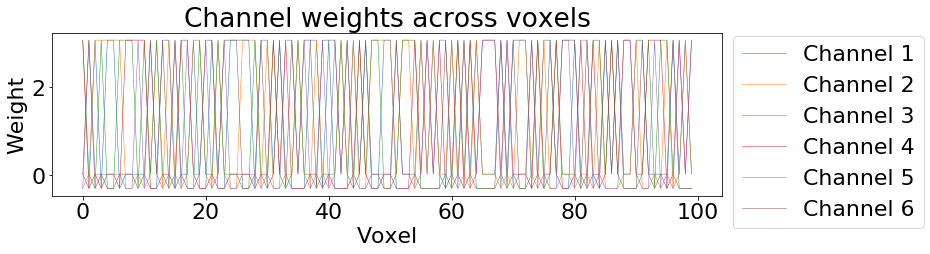

In [173]:
# Define training/testing trials
trn = trial_by_vox[:ntrials//2,:] # training: trial "Betas"
trnf = np.array(trial_features[:ntrials//2]) # training trial features
tst = trial_by_vox[ntrials//2:,:] # testing: trial "Betas"
tstf = np.array(trial_features[ntrials//2:]) # test trial features
trn_or_tst = np.hstack((np.full( len(trn) , 0), np.full( len(tst) , 1)))

channelweights_per_vox = np.linalg.lstsq(trial_weights[trn_or_tst==0,:], trn, rcond=None)[0] 
# solution of trial_weights @ w = trn; this is an exact solution if trial_weights is full rank

vox_idx = np.argmin(channelweights_per_vox[0,:])

for chan in range(nchannels):
    plt.plot(channelweights_per_vox[chan,:].T,linewidth=.5,label="Channel " + str(chan+1));
plt.title('Channel weights across voxels');
plt.xlabel("Voxel")
plt.ylabel("Weight")
plt.legend(bbox_to_anchor=(1, 1.05))

## Invert to compute channel responses

In [174]:
cr_trn = np.linalg.lstsq(channelweights_per_vox.T , trn.T, rcond=None)[0].T
cr_tst = np.linalg.lstsq(channelweights_per_vox.T , tst.T, rcond=None)[0].T

### Reconstruct training data (note: this is circular, it should be near-perfect!)

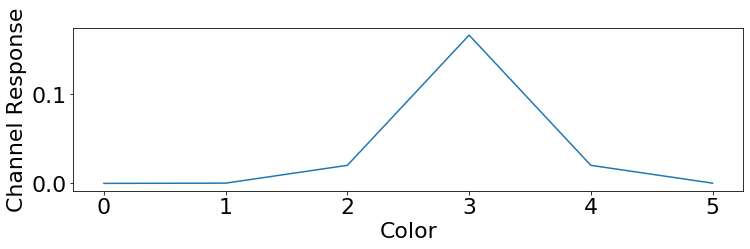

MAE: 3.0


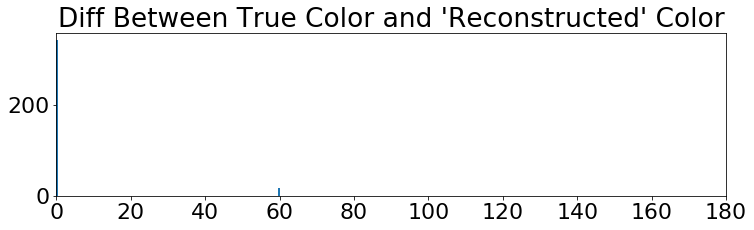

In [175]:
cr_center_trn = np.empty_like(cr_trn)
estimated_color = np.full(cr_center_trn.shape[0],np.nan)
shiftby = nchannels//2
for trial in np.arange(cr_trn.shape[0]):
    closest_basis = np.argmin( np.abs( wrap360(np.repeat(trnf[trial],len(basis_points)), basis_points) ) )
    cr_center_trn[trial,:] = np.roll( cr_trn[trial,:], shiftby - closest_basis );
    estimated_color[trial] = basis_points[np.argmax(cr_trn[trial,:])]
    
plt.plot(np.mean(cr_center_trn,axis=0))
plt.xlabel("Color")
plt.ylabel("Channel Response")
plt.show()

plt.hist(np.abs(wrap360(estimated_color, trnf)), bins=180, label="")
plt.xlim(xmin=0, xmax = 180)
plt.title("Diff Between True Color and 'Reconstructed' Color")

trn_mae = np.mean(np.abs(wrap360(estimated_color, trnf)))
print("MAE: {}".format(trn_mae))

### Reconstruct test data

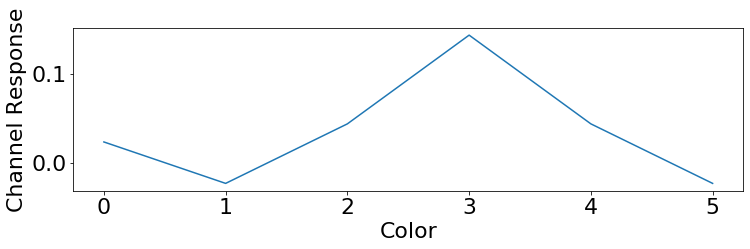

MAE: 6.833333333333333


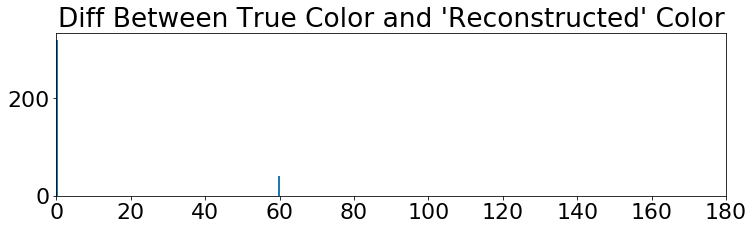

In [176]:
cr_center_tst = np.empty_like(cr_tst)
estimated_color = np.full(cr_center_tst.shape[0],np.nan)
shiftby = nchannels//2
for trial in np.arange(cr_tst.shape[0]):
    closest_basis = np.argmin( np.abs( wrap360(np.repeat(tstf[trial],len(basis_points)), basis_points) ) )
    cr_center_tst[trial,:] = np.roll( cr_tst[trial,:], shiftby - closest_basis );
    estimated_color[trial] = basis_points[np.argmax(cr_tst[trial,:])]
    
plt.plot(np.mean(cr_center_tst,axis=0))
plt.xlabel("Color")
plt.ylabel("Channel Response")
plt.show()

plt.hist(np.abs(wrap360(estimated_color, tstf)), bins=180, label="")
plt.xlim(xmin=0, xmax = 180)
plt.title("Diff Between True Color and 'Reconstructed' Color")

tst_mae = np.mean(np.abs(wrap360(estimated_color, tstf)))
print("MAE: {}".format(tst_mae))

### Null Distribution / Significance Test

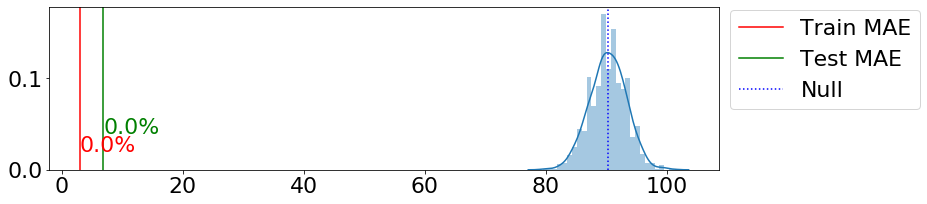

Model performance: 83.42933333333335


In [177]:
# Reconstruct the stimulus:
estimated_color = np.full(cr_tst.shape[0],np.nan)
null_mae = np.full(1000,np.nan)
for perm in np.arange(1000):
    shuffled_tst = np.random.permutation(tst)
    cr_shuffle_tst = np.linalg.lstsq(channelweights_per_vox.T , shuffled_tst.T, rcond=None)[0].T
    for trial in np.arange(cr_shuffle_tst.shape[0]):
        estimated_color[trial] = basis_points[np.argmax(cr_shuffle_tst[trial,:])]

    null_mae[perm] = np.mean(np.abs(wrap360(estimated_color, tstf)))

trn_overlap = len(null_mae[null_mae<trn_mae])/len(null_mae) * 100
tst_overlap = len(null_mae[null_mae<tst_mae])/len(null_mae) * 100

sns.distplot(null_mae)
plt.axvline(trn_mae,color='red',label="Train MAE")
plt.axvline(tst_mae,color='green',label="Test MAE")
plt.axvline(np.mean(null_mae),linestyle=':',color='blue',label="Null")
plt.legend(bbox_to_anchor=(1, 1.05))
plt.text(trn_mae,.02,"{:.1f}%".format(trn_overlap),color='red')
plt.text(tst_mae,.04,"{:.1f}%".format(tst_overlap),color='green')
plt.show()

print("Model performance: {}".format(np.mean(null_mae - tst_mae)))

# Compare With MVPA

Let's say we want to decode (e.g., classify) whether there is signal in our ROI that is different for conditions 1 and 2. Given all the voxels we have from half our dataset, can we decode above chance whether a trial was condition 1 or 2?

In [118]:
trn = trial_by_vox[:ntrials//2,:]
trn_cond = trial_conds[:ntrials//2]
trnf = trial_features[:ntrials//2]

tst = trial_by_vox[ntrials//2:,:]
tst_cond = trial_conds[ntrials//2:]
tstf = trial_features[ntrials//2:]

normalizer = StandardScaler()
trn = normalizer.fit_transform(trn)
tst = normalizer.fit_transform(tst)

In [119]:
model = LinearSVC(C=1)

model.fit(trn, trn_cond)

score = model.score(tst, tst_cond)
print('Accuracy = {}'.format(score))
print('Chance = 0.50')

Accuracy = 0.5133333333333333
Chance = 0.50


What if we want to decode the actual color?

MAE: 63.38666666666666


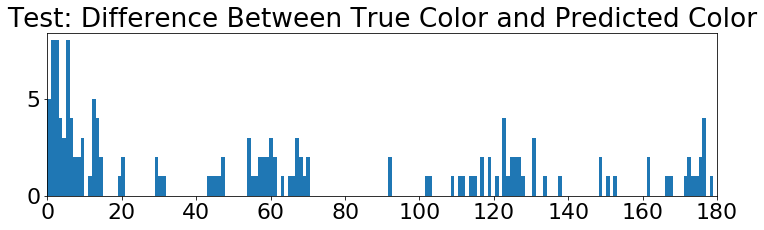

In [122]:
model.fit(trn, trnf)

predictions = model.predict(tst)

plt.hist(np.abs(wrap360(predictions, tstf)), bins=180, label="")
plt.xlim(xmin=0, xmax = 180)
plt.title("Test: Difference Between True Color and Predicted Color")

tst_mae = np.mean(np.abs(wrap360(predictions, tstf)))
print("MAE: {}".format(tst_mae))

# List Of Models
## Shared Precision

In [343]:
nchannels = 1
with pm.Model() as shared_k_1_channels:
        mus = [pm.Uniform('mu_%d' % i, 
                           lower = (2*np.pi)/nchannels*i - np.pi,
                           upper = ((2*np.pi)/nchannels*i + (2*np.pi)/nchannels) - np.pi) 
               for i in range(nchannels)] # 60 deg spaces

        # one shared precision parameter
        kappa = pm.Bound(pm.Gamma, lower = .609, upper = 33.33)('kappa',2.,.01) # 10 - 90 sd deg

        # weights of each mixture component
        p = pm.Dirichlet('p', a=np.array([1.]*(nchannels+1)))

        if (nchannels == 1):
            dists = [
                pm.Uniform.dist(lower=-np.pi,upper=np.pi),
                pm.VonMises.dist(mu=mus[0], kappa=kappa)
            ]
        elif (nchannels == 2): 
            dists = [
                pm.Uniform.dist(lower=-np.pi,upper=np.pi),
                pm.VonMises.dist(mu=mus[0], kappa=kappa),
                pm.VonMises.dist(mu=mus[1], kappa=kappa),
            ]
        elif (nchannels == 3):
            dists = [
                pm.Uniform.dist(lower=-np.pi,upper=np.pi),
                pm.VonMises.dist(mu=mus[0], kappa=kappa),
                pm.VonMises.dist(mu=mus[1], kappa=kappa),
                pm.VonMises.dist(mu=mus[2], kappa=kappa),
            ]
        elif (nchannels == 4):
            dists = [
                pm.Uniform.dist(lower=-np.pi,upper=np.pi),
                pm.VonMises.dist(mu=mus[0], kappa=kappa),
                pm.VonMises.dist(mu=mus[1], kappa=kappa),
                pm.VonMises.dist(mu=mus[2], kappa=kappa),
                pm.VonMises.dist(mu=mus[3], kappa=kappa),
            ]
        elif (nchannels == 5):
            dists = [
                pm.Uniform.dist(lower=-np.pi,upper=np.pi),
                pm.VonMises.dist(mu=mus[0], kappa=kappa),
                pm.VonMises.dist(mu=mus[1], kappa=kappa),
                pm.VonMises.dist(mu=mus[2], kappa=kappa),
                pm.VonMises.dist(mu=mus[3], kappa=kappa),
                pm.VonMises.dist(mu=mus[4], kappa=kappa),
            ]
        elif (nchannels == 6):
            dists = [
                pm.Uniform.dist(lower=-np.pi,upper=np.pi),
                pm.VonMises.dist(mu=mus[0], kappa=kappa),
                pm.VonMises.dist(mu=mus[1], kappa=kappa),
                pm.VonMises.dist(mu=mus[2], kappa=kappa),
                pm.VonMises.dist(mu=mus[3], kappa=kappa),
                pm.VonMises.dist(mu=mus[4], kappa=kappa),
                pm.VonMises.dist(mu=mus[5], kappa=kappa),
            ]
        elif (nchannels == 7):
            dists = [
                pm.Uniform.dist(lower=-np.pi,upper=np.pi),
                pm.VonMises.dist(mu=mus[0], kappa=kappa),
                pm.VonMises.dist(mu=mus[1], kappa=kappa),
                pm.VonMises.dist(mu=mus[2], kappa=kappa),
                pm.VonMises.dist(mu=mus[3], kappa=kappa),
                pm.VonMises.dist(mu=mus[4], kappa=kappa),
                pm.VonMises.dist(mu=mus[5], kappa=kappa),
                pm.VonMises.dist(mu=mus[6], kappa=kappa),
            ]
        elif (nchannels == 8):
            dists = [
                pm.Uniform.dist(lower=-np.pi,upper=np.pi),
                pm.VonMises.dist(mu=mus[0], kappa=kappa),
                pm.VonMises.dist(mu=mus[1], kappa=kappa),
                pm.VonMises.dist(mu=mus[2], kappa=kappa),
                pm.VonMises.dist(mu=mus[3], kappa=kappa),
                pm.VonMises.dist(mu=mus[4], kappa=kappa),
                pm.VonMises.dist(mu=mus[5], kappa=kappa),
                pm.VonMises.dist(mu=mus[6], kappa=kappa),
                pm.VonMises.dist(mu=mus[7], kappa=kappa),
            ]
        elif (nchannels == 9):
            dists = [
                pm.Uniform.dist(lower=-np.pi,upper=np.pi),
                pm.VonMises.dist(mu=mus[0], kappa=kappa),
                pm.VonMises.dist(mu=mus[1], kappa=kappa),
                pm.VonMises.dist(mu=mus[2], kappa=kappa),
                pm.VonMises.dist(mu=mus[3], kappa=kappa),
                pm.VonMises.dist(mu=mus[4], kappa=kappa),
                pm.VonMises.dist(mu=mus[5], kappa=kappa),
                pm.VonMises.dist(mu=mus[6], kappa=kappa),
                pm.VonMises.dist(mu=mus[7], kappa=kappa),
                pm.VonMises.dist(mu=mus[8], kappa=kappa),
            ]

        # Convenience transform: radians (-pi to pi) to degrees (0 to 359)
        mus_deg = [pm.Deterministic('mu_deg_%d' % i,
                                  np.rad2deg(mus[i]+np.pi))
                  for i in range(nchannels)]

        # Convenience transform: kappa (in radians) to sd (in degrees)
        sd_deg = pm.Deterministic('sd_deg',
                    k2sd_to_deg_op(kappa))

        # Specify the likelihood
        y = pm.Mixture('y', w=p, comp_dists=dists, observed=obs)

               
# nchannels = 2
# with pm.Model() as shared_k_2_channels:
#         mus = [pm.Uniform('mu_%d' % i, 
#                            lower = (2*np.pi)/nchannels*i - np.pi,
#                            upper = ((2*np.pi)/nchannels*i + (2*np.pi)/nchannels) - np.pi) 
#                for i in range(nchannels)] # 60 deg spaces

#         # one shared precision parameter
#         kappa = pm.Bound(pm.Gamma, lower = .609, upper = 33.33)('kappa',2.,.01) # 10 - 90 sd deg

#         # weights of each mixture component
#         p = pm.Dirichlet('p', a=np.array([1.]*(nchannels+1)))

#         if (nchannels == 1):
#             dists = [
#                 pm.Uniform.dist(lower=-np.pi,upper=np.pi),
#                 pm.VonMises.dist(mu=mus[0], kappa=kappa)
#             ]
#         elif (nchannels == 2): 
#             dists = [
#                 pm.Uniform.dist(lower=-np.pi,upper=np.pi),
#                 pm.VonMises.dist(mu=mus[0], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[1], kappa=kappa),
#             ]
#         elif (nchannels == 3):
#             dists = [
#                 pm.Uniform.dist(lower=-np.pi,upper=np.pi),
#                 pm.VonMises.dist(mu=mus[0], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[1], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[2], kappa=kappa),
#             ]
#         elif (nchannels == 4):
#             dists = [
#                 pm.Uniform.dist(lower=-np.pi,upper=np.pi),
#                 pm.VonMises.dist(mu=mus[0], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[1], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[2], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[3], kappa=kappa),
#             ]
#         elif (nchannels == 5):
#             dists = [
#                 pm.Uniform.dist(lower=-np.pi,upper=np.pi),
#                 pm.VonMises.dist(mu=mus[0], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[1], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[2], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[3], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[4], kappa=kappa),
#             ]
#         elif (nchannels == 6):
#             dists = [
#                 pm.Uniform.dist(lower=-np.pi,upper=np.pi),
#                 pm.VonMises.dist(mu=mus[0], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[1], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[2], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[3], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[4], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[5], kappa=kappa),
#             ]
#         elif (nchannels == 7):
#             dists = [
#                 pm.Uniform.dist(lower=-np.pi,upper=np.pi),
#                 pm.VonMises.dist(mu=mus[0], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[1], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[2], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[3], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[4], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[5], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[6], kappa=kappa),
#             ]
#         elif (nchannels == 8):
#             dists = [
#                 pm.Uniform.dist(lower=-np.pi,upper=np.pi),
#                 pm.VonMises.dist(mu=mus[0], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[1], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[2], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[3], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[4], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[5], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[6], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[7], kappa=kappa),
#             ]
#         elif (nchannels == 9):
#             dists = [
#                 pm.Uniform.dist(lower=-np.pi,upper=np.pi),
#                 pm.VonMises.dist(mu=mus[0], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[1], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[2], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[3], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[4], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[5], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[6], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[7], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[8], kappa=kappa),
#             ]

#         # Convenience transform: radians (-pi to pi) to degrees (0 to 359)
#         mus_deg = [pm.Deterministic('mu_deg_%d' % i,
#                                   np.rad2deg(mus[i]+np.pi))
#                   for i in range(nchannels)]

#         # Convenience transform: kappa (in radians) to sd (in degrees)
#         sd_deg = pm.Deterministic('sd_deg',
#                     k2sd_to_deg_op(kappa))

#         # Specify the likelihood
#         y = pm.Mixture('y', w=p, comp_dists=dists, observed=obs)
# nchannels = 3
# with pm.Model() as shared_k_3_channels:
#         mus = [pm.Uniform('mu_%d' % i, 
#                            lower = (2*np.pi)/nchannels*i - np.pi,
#                            upper = ((2*np.pi)/nchannels*i + (2*np.pi)/nchannels) - np.pi) 
#                for i in range(nchannels)] # 60 deg spaces

#         # one shared precision parameter
#         kappa = pm.Bound(pm.Gamma, lower = .609, upper = 33.33)('kappa',2.,.01) # 10 - 90 sd deg

#         # weights of each mixture component
#         p = pm.Dirichlet('p', a=np.array([1.]*(nchannels+1)))

#         if (nchannels == 1):
#             dists = [
#                 pm.Uniform.dist(lower=-np.pi,upper=np.pi),
#                 pm.VonMises.dist(mu=mus[0], kappa=kappa)
#             ]
#         elif (nchannels == 2): 
#             dists = [
#                 pm.Uniform.dist(lower=-np.pi,upper=np.pi),
#                 pm.VonMises.dist(mu=mus[0], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[1], kappa=kappa),
#             ]
#         elif (nchannels == 3):
#             dists = [
#                 pm.Uniform.dist(lower=-np.pi,upper=np.pi),
#                 pm.VonMises.dist(mu=mus[0], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[1], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[2], kappa=kappa),
#             ]
#         elif (nchannels == 4):
#             dists = [
#                 pm.Uniform.dist(lower=-np.pi,upper=np.pi),
#                 pm.VonMises.dist(mu=mus[0], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[1], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[2], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[3], kappa=kappa),
#             ]
#         elif (nchannels == 5):
#             dists = [
#                 pm.Uniform.dist(lower=-np.pi,upper=np.pi),
#                 pm.VonMises.dist(mu=mus[0], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[1], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[2], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[3], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[4], kappa=kappa),
#             ]
#         elif (nchannels == 6):
#             dists = [
#                 pm.Uniform.dist(lower=-np.pi,upper=np.pi),
#                 pm.VonMises.dist(mu=mus[0], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[1], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[2], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[3], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[4], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[5], kappa=kappa),
#             ]
#         elif (nchannels == 7):
#             dists = [
#                 pm.Uniform.dist(lower=-np.pi,upper=np.pi),
#                 pm.VonMises.dist(mu=mus[0], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[1], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[2], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[3], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[4], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[5], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[6], kappa=kappa),
#             ]
#         elif (nchannels == 8):
#             dists = [
#                 pm.Uniform.dist(lower=-np.pi,upper=np.pi),
#                 pm.VonMises.dist(mu=mus[0], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[1], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[2], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[3], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[4], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[5], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[6], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[7], kappa=kappa),
#             ]
#         elif (nchannels == 9):
#             dists = [
#                 pm.Uniform.dist(lower=-np.pi,upper=np.pi),
#                 pm.VonMises.dist(mu=mus[0], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[1], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[2], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[3], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[4], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[5], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[6], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[7], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[8], kappa=kappa),
#             ]

#         # Convenience transform: radians (-pi to pi) to degrees (0 to 359)
#         mus_deg = [pm.Deterministic('mu_deg_%d' % i,
#                                   np.rad2deg(mus[i]+np.pi))
#                   for i in range(nchannels)]

#         # Convenience transform: kappa (in radians) to sd (in degrees)
#         sd_deg = pm.Deterministic('sd_deg',
#                     k2sd_to_deg_op(kappa))

#         # Specify the likelihood
#         y = pm.Mixture('y', w=p, comp_dists=dists, observed=obs)
# nchannels = 4
# with pm.Model() as shared_k_4_channels:
#         mus = [pm.Uniform('mu_%d' % i, 
#                            lower = (2*np.pi)/nchannels*i - np.pi,
#                            upper = ((2*np.pi)/nchannels*i + (2*np.pi)/nchannels) - np.pi) 
#                for i in range(nchannels)] # 60 deg spaces

#         # one shared precision parameter
#         kappa = pm.Bound(pm.Gamma, lower = .609, upper = 33.33)('kappa',2.,.01) # 10 - 90 sd deg

#         # weights of each mixture component
#         p = pm.Dirichlet('p', a=np.array([1.]*(nchannels+1)))

#         if (nchannels == 1):
#             dists = [
#                 pm.Uniform.dist(lower=-np.pi,upper=np.pi),
#                 pm.VonMises.dist(mu=mus[0], kappa=kappa)
#             ]
#         elif (nchannels == 2): 
#             dists = [
#                 pm.Uniform.dist(lower=-np.pi,upper=np.pi),
#                 pm.VonMises.dist(mu=mus[0], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[1], kappa=kappa),
#             ]
#         elif (nchannels == 3):
#             dists = [
#                 pm.Uniform.dist(lower=-np.pi,upper=np.pi),
#                 pm.VonMises.dist(mu=mus[0], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[1], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[2], kappa=kappa),
#             ]
#         elif (nchannels == 4):
#             dists = [
#                 pm.Uniform.dist(lower=-np.pi,upper=np.pi),
#                 pm.VonMises.dist(mu=mus[0], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[1], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[2], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[3], kappa=kappa),
#             ]
#         elif (nchannels == 5):
#             dists = [
#                 pm.Uniform.dist(lower=-np.pi,upper=np.pi),
#                 pm.VonMises.dist(mu=mus[0], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[1], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[2], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[3], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[4], kappa=kappa),
#             ]
#         elif (nchannels == 6):
#             dists = [
#                 pm.Uniform.dist(lower=-np.pi,upper=np.pi),
#                 pm.VonMises.dist(mu=mus[0], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[1], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[2], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[3], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[4], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[5], kappa=kappa),
#             ]
#         elif (nchannels == 7):
#             dists = [
#                 pm.Uniform.dist(lower=-np.pi,upper=np.pi),
#                 pm.VonMises.dist(mu=mus[0], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[1], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[2], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[3], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[4], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[5], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[6], kappa=kappa),
#             ]
#         elif (nchannels == 8):
#             dists = [
#                 pm.Uniform.dist(lower=-np.pi,upper=np.pi),
#                 pm.VonMises.dist(mu=mus[0], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[1], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[2], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[3], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[4], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[5], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[6], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[7], kappa=kappa),
#             ]
#         elif (nchannels == 9):
#             dists = [
#                 pm.Uniform.dist(lower=-np.pi,upper=np.pi),
#                 pm.VonMises.dist(mu=mus[0], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[1], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[2], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[3], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[4], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[5], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[6], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[7], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[8], kappa=kappa),
#             ]

#         # Convenience transform: radians (-pi to pi) to degrees (0 to 359)
#         mus_deg = [pm.Deterministic('mu_deg_%d' % i,
#                                   np.rad2deg(mus[i]+np.pi))
#                   for i in range(nchannels)]

#         # Convenience transform: kappa (in radians) to sd (in degrees)
#         sd_deg = pm.Deterministic('sd_deg',
#                     k2sd_to_deg_op(kappa))

#         # Specify the likelihood
#         y = pm.Mixture('y', w=p, comp_dists=dists, observed=obs)
# nchannels = 5
# with pm.Model() as shared_k_5_channels:
#         mus = [pm.Uniform('mu_%d' % i, 
#                            lower = (2*np.pi)/nchannels*i - np.pi,
#                            upper = ((2*np.pi)/nchannels*i + (2*np.pi)/nchannels) - np.pi) 
#                for i in range(nchannels)] # 60 deg spaces

#         # one shared precision parameter
#         kappa = pm.Bound(pm.Gamma, lower = .609, upper = 33.33)('kappa',2.,.01) # 10 - 90 sd deg

#         # weights of each mixture component
#         p = pm.Dirichlet('p', a=np.array([1.]*(nchannels+1)))

#         if (nchannels == 1):
#             dists = [
#                 pm.Uniform.dist(lower=-np.pi,upper=np.pi),
#                 pm.VonMises.dist(mu=mus[0], kappa=kappa)
#             ]
#         elif (nchannels == 2): 
#             dists = [
#                 pm.Uniform.dist(lower=-np.pi,upper=np.pi),
#                 pm.VonMises.dist(mu=mus[0], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[1], kappa=kappa),
#             ]
#         elif (nchannels == 3):
#             dists = [
#                 pm.Uniform.dist(lower=-np.pi,upper=np.pi),
#                 pm.VonMises.dist(mu=mus[0], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[1], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[2], kappa=kappa),
#             ]
#         elif (nchannels == 4):
#             dists = [
#                 pm.Uniform.dist(lower=-np.pi,upper=np.pi),
#                 pm.VonMises.dist(mu=mus[0], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[1], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[2], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[3], kappa=kappa),
#             ]
#         elif (nchannels == 5):
#             dists = [
#                 pm.Uniform.dist(lower=-np.pi,upper=np.pi),
#                 pm.VonMises.dist(mu=mus[0], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[1], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[2], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[3], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[4], kappa=kappa),
#             ]
#         elif (nchannels == 6):
#             dists = [
#                 pm.Uniform.dist(lower=-np.pi,upper=np.pi),
#                 pm.VonMises.dist(mu=mus[0], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[1], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[2], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[3], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[4], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[5], kappa=kappa),
#             ]
#         elif (nchannels == 7):
#             dists = [
#                 pm.Uniform.dist(lower=-np.pi,upper=np.pi),
#                 pm.VonMises.dist(mu=mus[0], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[1], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[2], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[3], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[4], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[5], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[6], kappa=kappa),
#             ]
#         elif (nchannels == 8):
#             dists = [
#                 pm.Uniform.dist(lower=-np.pi,upper=np.pi),
#                 pm.VonMises.dist(mu=mus[0], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[1], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[2], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[3], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[4], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[5], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[6], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[7], kappa=kappa),
#             ]
#         elif (nchannels == 9):
#             dists = [
#                 pm.Uniform.dist(lower=-np.pi,upper=np.pi),
#                 pm.VonMises.dist(mu=mus[0], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[1], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[2], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[3], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[4], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[5], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[6], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[7], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[8], kappa=kappa),
#             ]

#         # Convenience transform: radians (-pi to pi) to degrees (0 to 359)
#         mus_deg = [pm.Deterministic('mu_deg_%d' % i,
#                                   np.rad2deg(mus[i]+np.pi))
#                   for i in range(nchannels)]

#         # Convenience transform: kappa (in radians) to sd (in degrees)
#         sd_deg = pm.Deterministic('sd_deg',
#                     k2sd_to_deg_op(kappa))

#         # Specify the likelihood
#         y = pm.Mixture('y', w=p, comp_dists=dists, observed=obs)
# nchannels = 6
# with pm.Model() as shared_k_6_channels:
#         mus = [pm.Uniform('mu_%d' % i, 
#                            lower = (2*np.pi)/nchannels*i - np.pi,
#                            upper = ((2*np.pi)/nchannels*i + (2*np.pi)/nchannels) - np.pi) 
#                for i in range(nchannels)] # 60 deg spaces

#         # one shared precision parameter
#         kappa = pm.Bound(pm.Gamma, lower = .609, upper = 33.33)('kappa',2.,.01) # 10 - 90 sd deg

#         # weights of each mixture component
#         p = pm.Dirichlet('p', a=np.array([1.]*(nchannels+1)))

#         if (nchannels == 1):
#             dists = [
#                 pm.Uniform.dist(lower=-np.pi,upper=np.pi),
#                 pm.VonMises.dist(mu=mus[0], kappa=kappa)
#             ]
#         elif (nchannels == 2): 
#             dists = [
#                 pm.Uniform.dist(lower=-np.pi,upper=np.pi),
#                 pm.VonMises.dist(mu=mus[0], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[1], kappa=kappa),
#             ]
#         elif (nchannels == 3):
#             dists = [
#                 pm.Uniform.dist(lower=-np.pi,upper=np.pi),
#                 pm.VonMises.dist(mu=mus[0], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[1], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[2], kappa=kappa),
#             ]
#         elif (nchannels == 4):
#             dists = [
#                 pm.Uniform.dist(lower=-np.pi,upper=np.pi),
#                 pm.VonMises.dist(mu=mus[0], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[1], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[2], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[3], kappa=kappa),
#             ]
#         elif (nchannels == 5):
#             dists = [
#                 pm.Uniform.dist(lower=-np.pi,upper=np.pi),
#                 pm.VonMises.dist(mu=mus[0], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[1], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[2], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[3], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[4], kappa=kappa),
#             ]
#         elif (nchannels == 6):
#             dists = [
#                 pm.Uniform.dist(lower=-np.pi,upper=np.pi),
#                 pm.VonMises.dist(mu=mus[0], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[1], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[2], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[3], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[4], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[5], kappa=kappa),
#             ]
#         elif (nchannels == 7):
#             dists = [
#                 pm.Uniform.dist(lower=-np.pi,upper=np.pi),
#                 pm.VonMises.dist(mu=mus[0], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[1], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[2], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[3], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[4], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[5], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[6], kappa=kappa),
#             ]
#         elif (nchannels == 8):
#             dists = [
#                 pm.Uniform.dist(lower=-np.pi,upper=np.pi),
#                 pm.VonMises.dist(mu=mus[0], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[1], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[2], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[3], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[4], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[5], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[6], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[7], kappa=kappa),
#             ]
#         elif (nchannels == 9):
#             dists = [
#                 pm.Uniform.dist(lower=-np.pi,upper=np.pi),
#                 pm.VonMises.dist(mu=mus[0], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[1], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[2], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[3], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[4], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[5], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[6], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[7], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[8], kappa=kappa),
#             ]

#         # Convenience transform: radians (-pi to pi) to degrees (0 to 359)
#         mus_deg = [pm.Deterministic('mu_deg_%d' % i,
#                                   np.rad2deg(mus[i]+np.pi))
#                   for i in range(nchannels)]

#         # Convenience transform: kappa (in radians) to sd (in degrees)
#         sd_deg = pm.Deterministic('sd_deg',
#                     k2sd_to_deg_op(kappa))

#         # Specify the likelihood
#         y = pm.Mixture('y', w=p, comp_dists=dists, observed=obs)
# nchannels = 7
# with pm.Model() as shared_k_7_channels:
#         mus = [pm.Uniform('mu_%d' % i, 
#                            lower = (2*np.pi)/nchannels*i - np.pi,
#                            upper = ((2*np.pi)/nchannels*i + (2*np.pi)/nchannels) - np.pi) 
#                for i in range(nchannels)] # 60 deg spaces

#         # one shared precision parameter
#         kappa = pm.Bound(pm.Gamma, lower = .609, upper = 33.33)('kappa',2.,.01) # 10 - 90 sd deg

#         # weights of each mixture component
#         p = pm.Dirichlet('p', a=np.array([1.]*(nchannels+1)))

#         if (nchannels == 1):
#             dists = [
#                 pm.Uniform.dist(lower=-np.pi,upper=np.pi),
#                 pm.VonMises.dist(mu=mus[0], kappa=kappa)
#             ]
#         elif (nchannels == 2): 
#             dists = [
#                 pm.Uniform.dist(lower=-np.pi,upper=np.pi),
#                 pm.VonMises.dist(mu=mus[0], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[1], kappa=kappa),
#             ]
#         elif (nchannels == 3):
#             dists = [
#                 pm.Uniform.dist(lower=-np.pi,upper=np.pi),
#                 pm.VonMises.dist(mu=mus[0], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[1], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[2], kappa=kappa),
#             ]
#         elif (nchannels == 4):
#             dists = [
#                 pm.Uniform.dist(lower=-np.pi,upper=np.pi),
#                 pm.VonMises.dist(mu=mus[0], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[1], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[2], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[3], kappa=kappa),
#             ]
#         elif (nchannels == 5):
#             dists = [
#                 pm.Uniform.dist(lower=-np.pi,upper=np.pi),
#                 pm.VonMises.dist(mu=mus[0], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[1], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[2], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[3], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[4], kappa=kappa),
#             ]
#         elif (nchannels == 6):
#             dists = [
#                 pm.Uniform.dist(lower=-np.pi,upper=np.pi),
#                 pm.VonMises.dist(mu=mus[0], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[1], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[2], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[3], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[4], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[5], kappa=kappa),
#             ]
#         elif (nchannels == 7):
#             dists = [
#                 pm.Uniform.dist(lower=-np.pi,upper=np.pi),
#                 pm.VonMises.dist(mu=mus[0], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[1], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[2], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[3], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[4], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[5], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[6], kappa=kappa),
#             ]
#         elif (nchannels == 8):
#             dists = [
#                 pm.Uniform.dist(lower=-np.pi,upper=np.pi),
#                 pm.VonMises.dist(mu=mus[0], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[1], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[2], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[3], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[4], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[5], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[6], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[7], kappa=kappa),
#             ]
#         elif (nchannels == 9):
#             dists = [
#                 pm.Uniform.dist(lower=-np.pi,upper=np.pi),
#                 pm.VonMises.dist(mu=mus[0], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[1], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[2], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[3], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[4], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[5], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[6], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[7], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[8], kappa=kappa),
#             ]

#         # Convenience transform: radians (-pi to pi) to degrees (0 to 359)
#         mus_deg = [pm.Deterministic('mu_deg_%d' % i,
#                                   np.rad2deg(mus[i]+np.pi))
#                   for i in range(nchannels)]

#         # Convenience transform: kappa (in radians) to sd (in degrees)
#         sd_deg = pm.Deterministic('sd_deg',
#                     k2sd_to_deg_op(kappa))

#         # Specify the likelihood
#         y = pm.Mixture('y', w=p, comp_dists=dists, observed=obs)
# nchannels = 8
# with pm.Model() as shared_k_8_channels:
#         mus = [pm.Uniform('mu_%d' % i, 
#                            lower = (2*np.pi)/nchannels*i - np.pi,
#                            upper = ((2*np.pi)/nchannels*i + (2*np.pi)/nchannels) - np.pi) 
#                for i in range(nchannels)] # 60 deg spaces

#         # one shared precision parameter
#         kappa = pm.Bound(pm.Gamma, lower = .609, upper = 33.33)('kappa',2.,.01) # 10 - 90 sd deg

#         # weights of each mixture component
#         p = pm.Dirichlet('p', a=np.array([1.]*(nchannels+1)))

#         if (nchannels == 1):
#             dists = [
#                 pm.Uniform.dist(lower=-np.pi,upper=np.pi),
#                 pm.VonMises.dist(mu=mus[0], kappa=kappa)
#             ]
#         elif (nchannels == 2): 
#             dists = [
#                 pm.Uniform.dist(lower=-np.pi,upper=np.pi),
#                 pm.VonMises.dist(mu=mus[0], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[1], kappa=kappa),
#             ]
#         elif (nchannels == 3):
#             dists = [
#                 pm.Uniform.dist(lower=-np.pi,upper=np.pi),
#                 pm.VonMises.dist(mu=mus[0], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[1], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[2], kappa=kappa),
#             ]
#         elif (nchannels == 4):
#             dists = [
#                 pm.Uniform.dist(lower=-np.pi,upper=np.pi),
#                 pm.VonMises.dist(mu=mus[0], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[1], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[2], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[3], kappa=kappa),
#             ]
#         elif (nchannels == 5):
#             dists = [
#                 pm.Uniform.dist(lower=-np.pi,upper=np.pi),
#                 pm.VonMises.dist(mu=mus[0], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[1], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[2], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[3], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[4], kappa=kappa),
#             ]
#         elif (nchannels == 6):
#             dists = [
#                 pm.Uniform.dist(lower=-np.pi,upper=np.pi),
#                 pm.VonMises.dist(mu=mus[0], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[1], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[2], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[3], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[4], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[5], kappa=kappa),
#             ]
#         elif (nchannels == 7):
#             dists = [
#                 pm.Uniform.dist(lower=-np.pi,upper=np.pi),
#                 pm.VonMises.dist(mu=mus[0], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[1], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[2], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[3], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[4], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[5], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[6], kappa=kappa),
#             ]
#         elif (nchannels == 8):
#             dists = [
#                 pm.Uniform.dist(lower=-np.pi,upper=np.pi),
#                 pm.VonMises.dist(mu=mus[0], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[1], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[2], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[3], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[4], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[5], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[6], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[7], kappa=kappa),
#             ]
#         elif (nchannels == 9):
#             dists = [
#                 pm.Uniform.dist(lower=-np.pi,upper=np.pi),
#                 pm.VonMises.dist(mu=mus[0], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[1], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[2], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[3], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[4], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[5], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[6], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[7], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[8], kappa=kappa),
#             ]

#         # Convenience transform: radians (-pi to pi) to degrees (0 to 359)
#         mus_deg = [pm.Deterministic('mu_deg_%d' % i,
#                                   np.rad2deg(mus[i]+np.pi))
#                   for i in range(nchannels)]

#         # Convenience transform: kappa (in radians) to sd (in degrees)
#         sd_deg = pm.Deterministic('sd_deg',
#                     k2sd_to_deg_op(kappa))

#         # Specify the likelihood
#         y = pm.Mixture('y', w=p, comp_dists=dists, observed=obs)
# nchannels = 9
# with pm.Model() as shared_k_9_channels:
#         mus = [pm.Uniform('mu_%d' % i, 
#                            lower = (2*np.pi)/nchannels*i - np.pi,
#                            upper = ((2*np.pi)/nchannels*i + (2*np.pi)/nchannels) - np.pi) 
#                for i in range(nchannels)] # 60 deg spaces

#         # one shared precision parameter
#         kappa = pm.Bound(pm.Gamma, lower = .609, upper = 33.33)('kappa',2.,.01) # 10 - 90 sd deg

#         # weights of each mixture component
#         p = pm.Dirichlet('p', a=np.array([1.]*(nchannels+1)))

#         if (nchannels == 1):
#             dists = [
#                 pm.Uniform.dist(lower=-np.pi,upper=np.pi),
#                 pm.VonMises.dist(mu=mus[0], kappa=kappa)
#             ]
#         elif (nchannels == 2): 
#             dists = [
#                 pm.Uniform.dist(lower=-np.pi,upper=np.pi),
#                 pm.VonMises.dist(mu=mus[0], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[1], kappa=kappa),
#             ]
#         elif (nchannels == 3):
#             dists = [
#                 pm.Uniform.dist(lower=-np.pi,upper=np.pi),
#                 pm.VonMises.dist(mu=mus[0], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[1], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[2], kappa=kappa),
#             ]
#         elif (nchannels == 4):
#             dists = [
#                 pm.Uniform.dist(lower=-np.pi,upper=np.pi),
#                 pm.VonMises.dist(mu=mus[0], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[1], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[2], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[3], kappa=kappa),
#             ]
#         elif (nchannels == 5):
#             dists = [
#                 pm.Uniform.dist(lower=-np.pi,upper=np.pi),
#                 pm.VonMises.dist(mu=mus[0], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[1], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[2], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[3], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[4], kappa=kappa),
#             ]
#         elif (nchannels == 6):
#             dists = [
#                 pm.Uniform.dist(lower=-np.pi,upper=np.pi),
#                 pm.VonMises.dist(mu=mus[0], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[1], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[2], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[3], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[4], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[5], kappa=kappa),
#             ]
#         elif (nchannels == 7):
#             dists = [
#                 pm.Uniform.dist(lower=-np.pi,upper=np.pi),
#                 pm.VonMises.dist(mu=mus[0], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[1], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[2], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[3], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[4], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[5], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[6], kappa=kappa),
#             ]
#         elif (nchannels == 8):
#             dists = [
#                 pm.Uniform.dist(lower=-np.pi,upper=np.pi),
#                 pm.VonMises.dist(mu=mus[0], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[1], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[2], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[3], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[4], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[5], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[6], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[7], kappa=kappa),
#             ]
#         elif (nchannels == 9):
#             dists = [
#                 pm.Uniform.dist(lower=-np.pi,upper=np.pi),
#                 pm.VonMises.dist(mu=mus[0], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[1], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[2], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[3], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[4], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[5], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[6], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[7], kappa=kappa),
#                 pm.VonMises.dist(mu=mus[8], kappa=kappa),
#             ]

#         # Convenience transform: radians (-pi to pi) to degrees (0 to 359)
#         mus_deg = [pm.Deterministic('mu_deg_%d' % i,
#                                   np.rad2deg(mus[i]+np.pi))
#                   for i in range(nchannels)]

#         # Convenience transform: kappa (in radians) to sd (in degrees)
#         sd_deg = pm.Deterministic('sd_deg',
#                     k2sd_to_deg_op(kappa))

#         # Specify the likelihood
#         y = pm.Mixture('y', w=p, comp_dists=dists, observed=obs)


In [313]:
nchannels=6
with pm.Model() as shared_k_6_channels:
    mus = [pm.Uniform('mu_%d' % i, 
                       lower = (2*np.pi)/nchannels*i - np.pi,
                       upper = ((2*np.pi)/nchannels*i + (2*np.pi)/nchannels) - np.pi) 
           for i in range(nchannels)] # 60 deg spaces
    
    # one shared precision parameter
    kappa = pm.Bound(pm.Gamma, lower = .609, upper = 33.33)('kappa',2.,.01) # 10 - 90 sd deg
    
    # weights of each mixture component
    p = pm.Dirichlet('p', a=np.array([1.]*(nchannels+1)))
    
    dists = [
        pm.Uniform.dist(lower=-np.pi,upper=np.pi),
        pm.VonMises.dist(mu=mus[0], kappa=kappa),
        pm.VonMises.dist(mu=mus[1], kappa=kappa),
        pm.VonMises.dist(mu=mus[2], kappa=kappa),
        pm.VonMises.dist(mu=mus[3], kappa=kappa),
        pm.VonMises.dist(mu=mus[4], kappa=kappa),
        pm.VonMises.dist(mu=mus[5], kappa=kappa),
    ]
    
    # Convenience transform: radians (-pi to pi) to degrees (0 to 359)
    mus_deg = [pm.Deterministic('mu_deg_%d' % i,
                              np.rad2deg(mus[i]+np.pi))
              for i in range(nchannels)]
    
    # Convenience transform: kappa (in radians) to sd (in degrees)
    sd_deg = pm.Deterministic('sd_deg',
                k2sd_to_deg_op(kappa))
    
    # Specify the likelihood
    y = pm.Mixture('y', w=p, comp_dists=dists, observed=obs)


## Individual Precisions

In [ ]:
nchannels=6
with pm.Model() as indiv_k_6_channels:
    mus = [pm.Uniform('mu_%d' % i, 
                       lower = (2*np.pi)/nchannels*i - np.pi,
                       upper = ((2*np.pi)/nchannels*i + (2*np.pi)/nchannels) - np.pi) 
           for i in range(nchannels)] # 60 deg spaces
    
    # separate precision parameters per channel
    kappas = [pm.Bound(pm.Gamma,
                   lower = .609, # 90 deg sd
                   upper = 33.33) # 10 deg sd
             ('kappa_%d' % i,2.,.01)
             for i in range(nchannels)]
    
    # weights of each mixture component
    p = pm.Dirichlet('p', a=np.array([1.]*(nchannels+1)))
    
    dists = [
        pm.Uniform.dist(lower=-np.pi,upper=np.pi),
        pm.VonMises.dist(mu=mus[0], kappa=kappas[0]),
        pm.VonMises.dist(mu=mus[1], kappa=kappas[1]),
        pm.VonMises.dist(mu=mus[2], kappa=kappas[2]),
        pm.VonMises.dist(mu=mus[3], kappa=kappas[3]),
        pm.VonMises.dist(mu=mus[4], kappa=kappas[4]),
        pm.VonMises.dist(mu=mus[5], kappa=kappas[5]),
    ]
    
    # Convenience transform: radians (-pi to pi) to degrees (0 to 359)
    mus_deg = [pm.Deterministic('mu_deg_%d' % i,
                              np.rad2deg(mus[i]+np.pi))
              for i in range(nchannels)]
    
    # Convenience transform: kappa (in radians) to sd (in degrees)
    sds = [pm.Deterministic('sd_deg_%d' % i,
                k2sd_to_deg_op(kappas[i]))
          for i in range(nchannels)]
    
    # Specify the likelihood
    y = pm.Mixture('y', w=p, comp_dists=dists, observed=obs)


# scratch

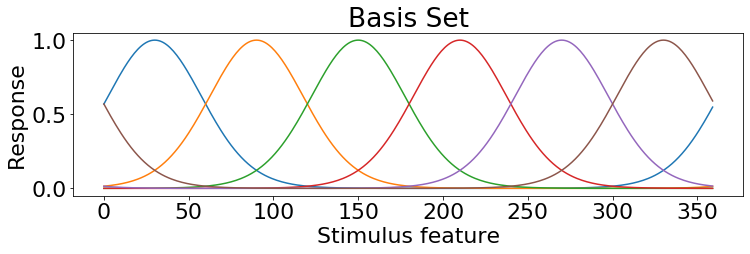

In [231]:
# Plot chosen basis set
plt.plot(make_vonmises_iter(np.linspace(0,359,360),np.array([0,60,120,180,240,300])+30,np.ones(nchannels)*30,np.ones(nchannels)))
plt.title('Basis Set') 
plt.ylabel('Response')
plt.xlabel('Stimulus feature')
plt.show()

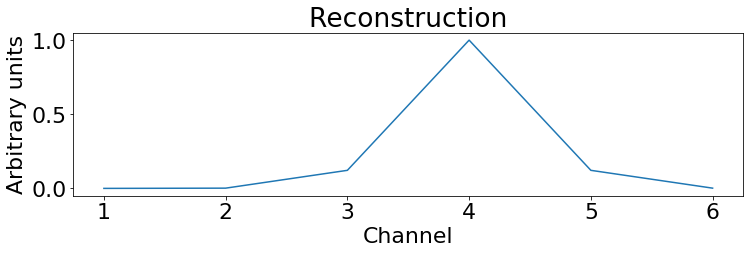

In [63]:
# Plot chosen basis set
a=make_vonmises(np.linspace(0,359,360),360/2,np.ones(1)*30)
plt.plot(np.linspace(1,6,6),a[[0,60,120,180,240,300]])
plt.title('Reconstruction') 
plt.ylabel('Arbitrary units')
plt.xlabel("Channel")
plt.show()

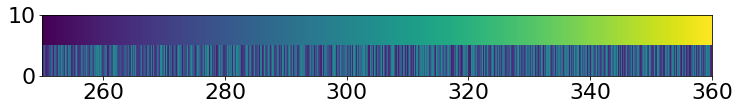

In [70]:
plt.imshow([np.linspace(0,720,720),trial_features], extent=[250,360,0,10])
# plt.axis('off')

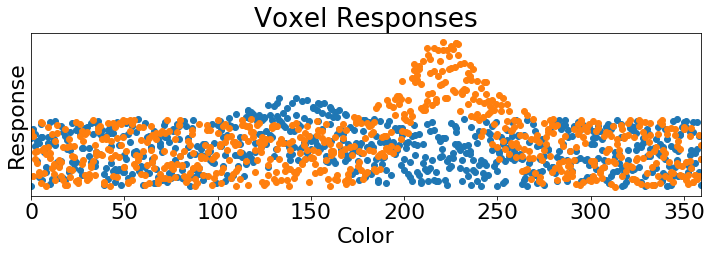

In [261]:
# Plot actual voxel tunings:
for vox in np.arange(nvoxels):
    if vox < 3:
        plt.scatter(trial_features,trial_by_vox[:,vox])
plt.xlabel('Color')
plt.ylabel('Response')
plt.yticks([]); plt.xlim([0,359])
plt.title('Voxel Responses')
plt.show()

In [97]:
save_obj([vox_dist, trial_features, trial_conds, vox_betas, features, trial_by_vox, obs], 'save_data')

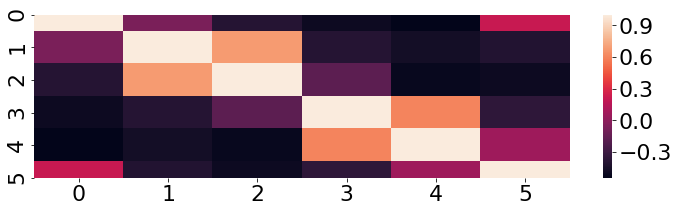

In [115]:
sns.heatmap(np.corrcoef(trial_by_vox[0:359:60,:]))


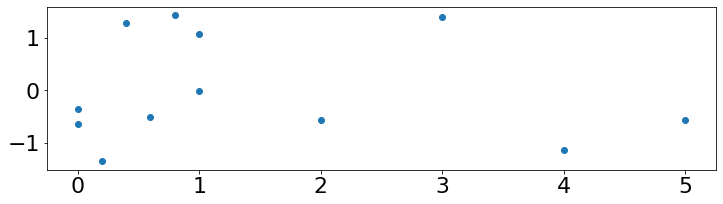

In [149]:
clf = manifold.MDS(n_components=2, n_init=1, max_iter=100)

X_mds = clf.fit_transform(np.corrcoef(trial_by_vox[0:359:60,:]))

plt.scatter([np.linspace(0,1,6),np.linspace(0,5,6)],X_mds)